In [95]:
import math
import copy 
import numpy as np
from scipy.special import erfinv
from scipy.stats import norm
from scipy.optimize import fsolve
from scipy.optimize import bisect
import numpy.random as rng
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy 
from tqdm import tqdm
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
class MLP_variant(nn.Module):
    def __init__(self, N, p, num_nodes, ac_func='relu', dropout=0):
        super(MLP_variant, self).__init__()
        fc = []
        last_node = N
        for node in num_nodes:
            fc.append(nn.Linear(last_node, node))
            last_node = node 
        self.fc_final = nn.Linear(last_node, p)
        self.fc = nn.ModuleList(fc)
        assert ac_func in ('relu', 'tanh', 'leakyrelu', 'softplus', 'softsign', 'selu', 'elu')
        if ac_func == 'relu':
            self.activation = nn.ReLU()
        elif ac_func == 'tanh':
            self.activation = nn.Tanh()
        elif ac_func == 'leakyrelu':
            self.activation = nn.LeakyReLU()
        elif ac_func == 'softplus':
            self.activation = nn.Softplus()
        elif ac_func == 'softsign':
            self.activation = nn.Softsign()
        elif ac_func == 'selu':
            self.activation = nn.SELU()
        elif ac_func == 'elu':
            self.activation = nn.ELU()
        self.mseloss = nn.MSELoss()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        for m in self.fc:
            x = self.dropout(self.activation(m(x)))
        x = self.fc_final(x)
        return x 
    
    def get_mseloss(self, data, targ):
        output = self.forward(data)
        loss = self.mseloss(output, targ)
        return loss 

    def get_quanloss(self, data, targ, tau):
        output = self.forward(data)
        errs = targ - output 
        loss = torch.mean(torch.max((tau-1)*errs, tau*errs))
        return loss         

In [3]:
class Generator_doubleNormal(object):
    def __init__(self, p, theta, sigma0, sigma1, sigma=1) -> None:
        self.p = p 
        self.theta = theta 
        self.sigma0 = sigma0
        self.sigma1 = sigma1 
        self.sigma = sigma
        self.X = np.eye(p)
    
    def generate_samples(self, n):
        theta = np.ones((n, self.p)) * self.theta
        gamma = rng.binomial(1, theta)
        beta = np.zeros((n, self.p))
        beta[gamma == 1] = rng.randn(np.sum(gamma == 1)) * self.sigma1
        beta[gamma == 0] = rng.randn(np.sum(gamma == 0)) * self.sigma0 
        Y = beta@self.X.T + rng.randn(n, self.p) * self.sigma 
        return gamma, beta, Y 

In [4]:
'''
modified train function
'''
''' 
 loss_type: 'mse' for posterior mean, 'bce' for predicting whether beta is 0, 'quantile' for posterior quantile.
q: Only used when loss_type is 'quantile', q quantile.
'''
def train_epoch(model, optimizer, data_loader, loss_type, q, kwards):
    model.train()
    n = 0
    train_loss = 0.
    for _, (data, targ) in enumerate(data_loader):
        data, targ = data.to(device), targ.to(device)
        if loss_type == 'mse':
            loss = model.get_mseloss(data, targ)
        elif loss_type == 'bce':
            loss = model.get_bceloss(data, targ)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(data, targ, q)
        train_loss += loss.item() * data.shape[0]   
        n += data.shape[0]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if 'scheduler' in kwards:
        kwards['scheduler'].step()
    return train_loss/n
             
def model_test(model, data_loader, loss_type='mse', q=0.5):
    model.eval()
    with torch.no_grad():
        n = 0 
        total_loss = 0.
        for _, (data, targ) in enumerate(data_loader):
            data, targ = data.to(device), targ.to(device)
            if loss_type == 'mse':
                loss = model.get_mseloss(data, targ)
            elif loss_type == 'bce':
                loss = model.get_bceloss(data, targ)
            elif loss_type == 'quantile':
                loss = model.get_quanloss(data, targ, q)
            total_loss += loss.item() * data.shape[0]
            n += data.shape[0]
    return total_loss/n

def train_model(model, model_es, optimizer, epochs, train_data, loss_type='mse', q=0.5, val_data=None, early_stop=10, **kwargs):
    assert loss_type in ['mse', 'bce', 'quantile']
    train_losses = []
    val_losses = []
    min_loss = 1e6
    es_count = 0
    es_flag = 0
    for i in range(epochs):
        train_loss = train_epoch(model, optimizer, train_data, loss_type, q, kwargs)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
            if val_loss <= min_loss:
                min_loss = val_loss
                es_count = 0
            if (es_count >= early_stop) and (es_flag == 0):
                es_flag = 1
                print('Save early stopping model at epoch {}'.format(i+1))
                model_es.load_state_dict(deepcopy(model.state_dict()))
            es_count += 1
    return train_losses, val_losses

def predict(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = model(data)
    return pred.detach().cpu().numpy()

def show_loss(train_losses, val_losses):
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), val_losses)
    plt.legend(['train loss', 'val loss'], loc="upper right")
    plt.show()

def predict_class(model, Y):
    model.eval()
    with torch.no_grad():
        data = torch.from_numpy(Y).type(torch.float).to(device)
        pred = torch.sigmoid(model(data))
    return pred.detach().cpu().numpy()

In [186]:
def train_epoch_with_generator(model, optimizer, generator, batch_size, iteration, loss_type, q, kwards):
    model.train()
    train_loss = 0.
    for i in range(iteration):
        gamma, beta, Y = generator.generate_samples(batch_size)
        Y = (Y - kwards['mean']) / kwards['std']
        gamma = torch.from_numpy(gamma).type(torch.float).to(device)
        beta = torch.from_numpy(beta).type(torch.float).to(device)
        Y = torch.from_numpy(Y).type(torch.float).to(device)

        if loss_type == 'mse':
            loss = model.get_mseloss(Y, beta)
        elif loss_type == 'bce':
            loss = model.get_bceloss(Y, gamma)
        elif loss_type == 'quantile':
            loss = model.get_quanloss(Y, beta, q)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if 'scheduler' in kwards:
        kwards['scheduler'].step()
    return train_loss/(i+1)

# Input mean and std to normalize input.
def train_model_with_generator(model, generator, optimizer, epochs, batch_size, iteration_per_epoch, loss_type='mse', q=0.5, val_data=None, **kwargs):
    assert loss_type in ['mse', 'bce', 'quantile']
    train_losses = []
    val_losses = []
    for i in range(epochs):
        train_loss = train_epoch_with_generator(
            model, optimizer, generator, batch_size, iteration_per_epoch, loss_type, q, kwargs)
        print('Epoch: {}'.format(i+1))
        print('Train loss: {:.5f}'.format(train_loss))
        train_losses.append(train_loss)
        if val_data.__str__() != 'None':
            val_loss = model_test(model, val_data, loss_type, q)
            print('Val loss: {:.5f}'.format(val_loss))
            val_losses.append(val_loss)
        if 'model_list' in kwargs:
            if (i+1) in kwargs['save_point']:
                kwargs['model_list'].append(deepcopy(model.state_dict()))
    return train_losses, val_losses

In [6]:
'''
The posterior is also a Gaussian mixture of two components. The posterior mean is easy to compute. However, the 
quantile doesn't have close form solution. Use fsolve in scipy.optimize to solve equations for quantile.
'''
def computeNormalStats(sigma, sigma0, sigma1, Y):
    tau = 1 / sigma**2
    tau0 = 1 / sigma0**2
    tau1 = 1 / sigma1**2
    tau0_ = tau0 + tau 
    tau1_ = tau1 + tau 
    theta_ = theta / (theta + (1-theta) * np.sqrt(tau1_*tau0/(tau0_*tau1)) \
        * np.exp(-0.5 * tau**2 * (tau0_-tau1_) / (tau0_*tau1_) * Y**2))
    mu1 = tau / tau1_ * Y 
    mu0 = tau / tau0_ * Y 
    true_mean = theta_ * mu1 + (1-theta_) * mu0
    # Use different initial values according to Y to avoid solver failure.
    if np.abs(Y) > 4:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, Y)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, Y)
    else:
        q025 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.025, 0)
        q975 = fsolve(lambda x: theta_ * norm.cdf(x, mu1, (1/tau1_)**0.5) + (1-theta_) * norm.cdf(x, mu0, (1/tau0_)**0.5) - 0.975, 0)        
    return true_mean, q025, q975

In [14]:
def computeDiffMetrics(md_mean, md_q025, md_q975, sigma, sigma0, sigma1, mean, std, Y_test, beta_test):
    Y_test_norm = (Y_test - mean) / std
    
    pred_mean_test = predict(md_mean, Y_test_norm)
    pred_q025_test = predict(md_q025, Y_test_norm)
    pred_q975_test = predict(md_q975, Y_test_norm)
    true_mean_test = np.zeros_like(pred_mean_test)
    true_q025_test = np.zeros_like(pred_q025_test)
    true_q975_test = np.zeros_like(pred_q975_test)
    
    for i in tqdm(range(pred_mean_test.shape[0])):
        for j in range(pred_mean_test.shape[1]):
            true_mean_test[i,j], true_q025_test[i, j], true_q975_test[i, j] \
            = computeNormalStats(sigma, sigma0, sigma1, Y_test[i, j])
            
    opt_mean_test = np.mean((beta_test-true_mean_test)**2)    # theoretical minimum of the loss 
    mse_mean_test = np.mean((true_mean_test-pred_mean_test)**2) # mean square error between prediction and true
    opt_q025_test = np.mean(np.maximum(0.025*(beta_test-true_q025_test),0.975*(true_q025_test-beta_test)))
    mse_q025_test = np.mean((true_q025_test-pred_q025_test)**2)
    opt_q975_test = np.mean(np.maximum(0.975*(beta_test-true_q975_test),0.025*(true_q975_test-beta_test)))
    mse_q975_test = np.mean((true_q975_test-pred_q975_test)**2)   
    
    test_matric = {'opt mean test': opt_mean_test, 'mse mean test': mse_mean_test, 
                   'opt q025 test': opt_q025_test, 'mse q025 test': mse_q025_test, 
                   'opt q975 test': opt_q975_test, 'mse q975 test': mse_q975_test}
    return test_matric

In [7]:
theta = 0.05
sigma0 = 0.1
sigma1 = 5
sigma = 1
lr = 0.001 # learning rate
p = 50
generator = Generator_doubleNormal(p, theta, sigma0, sigma1)

rng.seed(0)
gamma_train, beta_train, Y_train = generator.generate_samples(1000000)
gamma_val, beta_val, Y_val = generator.generate_samples(10000)

rng.seed(1)
gamma_test, beta_test, Y_test = generator.generate_samples(10000)

mean = Y_train.mean(0)
std = Y_train.std(0)

val_dataset = TensorDataset(torch.Tensor((Y_val - mean) / std), torch.Tensor(beta_val))
valid_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))

Y_test_normalized = (Y_test - mean) / std

In [8]:
md_q025 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q025.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.02314
Val loss: 0.02021
Epoch: 2
Train loss: 0.01985
Val loss: 0.01975
Epoch: 3
Train loss: 0.01947
Val loss: 0.01961
Epoch: 4
Train loss: 0.01924
Val loss: 0.01937
Epoch: 5
Train loss: 0.01911
Val loss: 0.01928
Epoch: 6
Train loss: 0.01905
Val loss: 0.01913
Epoch: 7
Train loss: 0.01895
Val loss: 0.01907
Epoch: 8
Train loss: 0.01893
Val loss: 0.01909
Epoch: 9
Train loss: 0.01887
Val loss: 0.01905
Epoch: 10
Train loss: 0.01888
Val loss: 0.01895
Epoch: 11
Train loss: 0.01883
Val loss: 0.01894
Epoch: 12
Train loss: 0.01878
Val loss: 0.01889
Epoch: 13
Train loss: 0.01879
Val loss: 0.01886
Epoch: 14
Train loss: 0.01875
Val loss: 0.01884
Epoch: 15
Train loss: 0.01875
Val loss: 0.01884
Epoch: 16
Train loss: 0.01871
Val loss: 0.01882
Epoch: 17
Train loss: 0.01867
Val loss: 0.01887
Epoch: 18
Train loss: 0.01868
Val loss: 0.01880
Epoch: 19
Train loss: 0.01867
Val loss: 0.01881
Epoch: 20
Train loss: 0.01865
Val loss: 0.01875
Epoch: 21
Train loss: 0.01825
Val loss: 0.01832
E

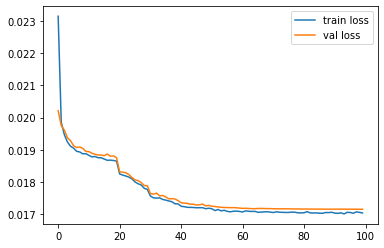

In [9]:
show_loss(train_losses, val_losses)

In [10]:
md_q975 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_q975.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.02311
Val loss: 0.01982
Epoch: 2
Train loss: 0.01986
Val loss: 0.01942
Epoch: 3
Train loss: 0.01950
Val loss: 0.01911
Epoch: 4
Train loss: 0.01930
Val loss: 0.01885
Epoch: 5
Train loss: 0.01916
Val loss: 0.01876
Epoch: 6
Train loss: 0.01907
Val loss: 0.01878
Epoch: 7
Train loss: 0.01899
Val loss: 0.01874
Epoch: 8
Train loss: 0.01896
Val loss: 0.01869
Epoch: 9
Train loss: 0.01891
Val loss: 0.01861
Epoch: 10
Train loss: 0.01889
Val loss: 0.01862
Epoch: 11
Train loss: 0.01883
Val loss: 0.01859
Epoch: 12
Train loss: 0.01881
Val loss: 0.01850
Epoch: 13
Train loss: 0.01880
Val loss: 0.01841
Epoch: 14
Train loss: 0.01877
Val loss: 0.01845
Epoch: 15
Train loss: 0.01877
Val loss: 0.01846
Epoch: 16
Train loss: 0.01873
Val loss: 0.01853
Epoch: 17
Train loss: 0.01871
Val loss: 0.01841
Epoch: 18
Train loss: 0.01870
Val loss: 0.01845
Epoch: 19
Train loss: 0.01870
Val loss: 0.01843
Epoch: 20
Train loss: 0.01869
Val loss: 0.01835
Epoch: 21
Train loss: 0.01827
Val loss: 0.01793
E

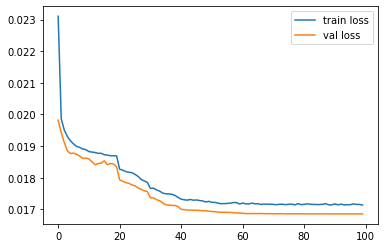

In [11]:
show_loss(train_losses, val_losses)

In [12]:
md_mean = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
optimizer = torch.optim.Adam(md_mean.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_mean, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='mse',
                                      val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std)

Epoch: 1
Train loss: 0.18355
Val loss: 0.14199
Epoch: 2
Train loss: 0.14062
Val loss: 0.13848
Epoch: 3
Train loss: 0.13815
Val loss: 0.13717
Epoch: 4
Train loss: 0.13755
Val loss: 0.13648
Epoch: 5
Train loss: 0.13698
Val loss: 0.13612
Epoch: 6
Train loss: 0.13665
Val loss: 0.13572
Epoch: 7
Train loss: 0.13640
Val loss: 0.13611
Epoch: 8
Train loss: 0.13609
Val loss: 0.13549
Epoch: 9
Train loss: 0.13588
Val loss: 0.13476
Epoch: 10
Train loss: 0.13563
Val loss: 0.13447
Epoch: 11
Train loss: 0.13571
Val loss: 0.13466
Epoch: 12
Train loss: 0.13546
Val loss: 0.13507
Epoch: 13
Train loss: 0.13503
Val loss: 0.13527
Epoch: 14
Train loss: 0.13508
Val loss: 0.13461
Epoch: 15
Train loss: 0.13486
Val loss: 0.13438
Epoch: 16
Train loss: 0.13483
Val loss: 0.13361
Epoch: 17
Train loss: 0.13479
Val loss: 0.13367
Epoch: 18
Train loss: 0.13475
Val loss: 0.13328
Epoch: 19
Train loss: 0.13446
Val loss: 0.13368
Epoch: 20
Train loss: 0.13445
Val loss: 0.13344
Epoch: 21
Train loss: 0.12947
Val loss: 0.12856
E

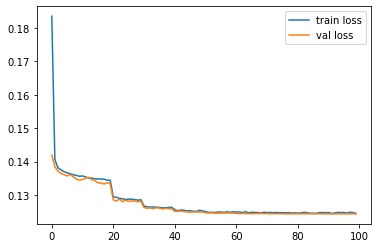

In [13]:
show_loss(train_losses, val_losses)

In [15]:
computeDiffMetrics(md_mean, md_q025, md_q975, sigma, sigma0, sigma1, mean, std, 
                   Y_test[:2000], beta_test[:2000])

100%|██████████| 2000/2000 [08:19<00:00,  4.01it/s]


{'opt mean test': 0.12270699811469067,
 'mse mean test': 0.0017561706,
 'opt q025 test': 0.016490322669509682,
 'mse q025 test': 0.07024183,
 'opt q975 test': 0.016984371938458382,
 'mse q975 test': 0.104955114}

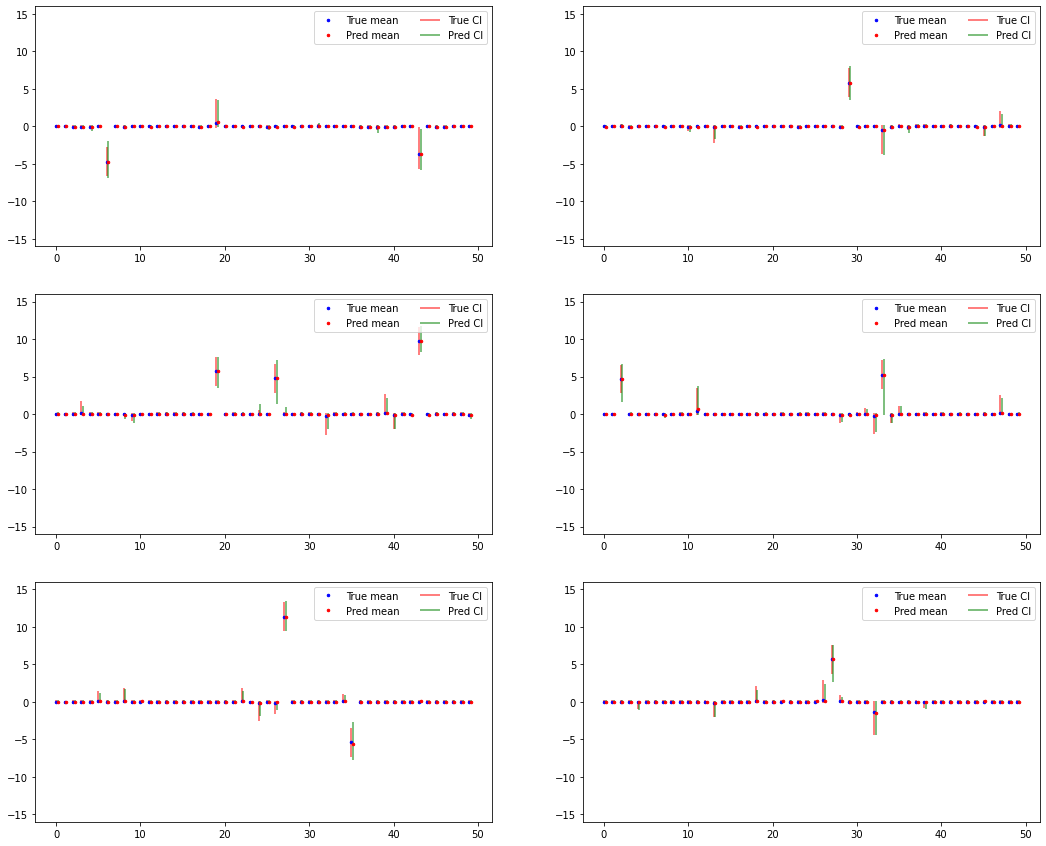

In [16]:
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)
pred_mean = predict(md_mean, Y_test_normalized)

true_mean = np.zeros_like(beta_test)
true_q025 = np.zeros_like(pred_q025)
true_q975 = np.zeros_like(pred_q975)

subset = np.where(np.abs(beta_test)>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

In [17]:
subset

array([7003, 1853, 7502, 3869, 1208, 1610], dtype=int64)

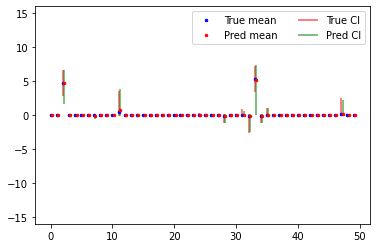

In [18]:
plt.plot(range(p), true_mean[3869], '.b', ms=5)
plt.plot(np.arange(p)+0.2, pred_mean[3869], '.r', ms=5)
plt.vlines(np.arange(p), true_q025[3869], true_q975[3869], color='red', alpha=0.5, lw=2)
plt.vlines(np.arange(p)+0.2, pred_q025[3869], pred_q975[3869], color='green', alpha=0.5, lw=2)
plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
plt.ylim(-16,16)
plt.show()

In [19]:
np.where(pred_mean[3869]>1)

(array([ 2, 33], dtype=int64),)

Sample 3869's coordinate 33 is abnormal. Then check samples with $\beta_{33} \neq 0$.

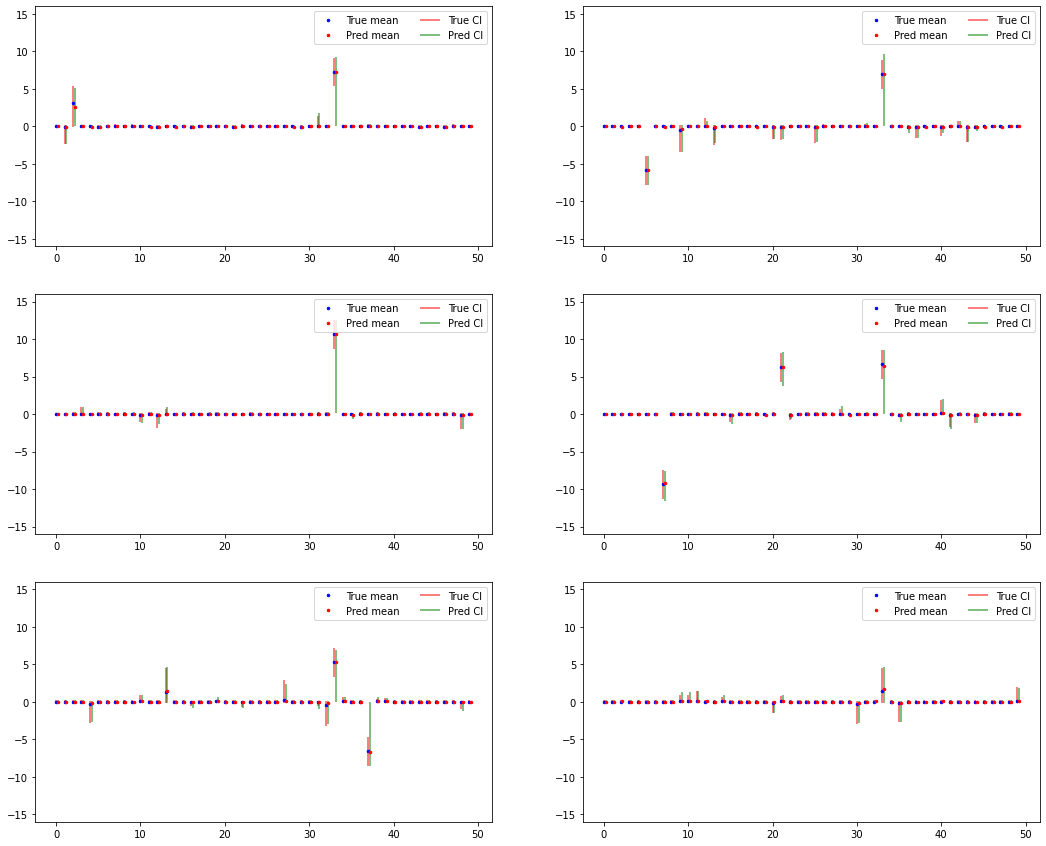

In [24]:
subset = np.where(beta_test[:,33]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

In [26]:
subset

array([ 607, 8270, 5297, 1751, 8162, 2980], dtype=int64)

In [27]:
np.where(pred_mean[8162]<-1)

(array([37], dtype=int64),)

Coordinate 37 is also abnormal.

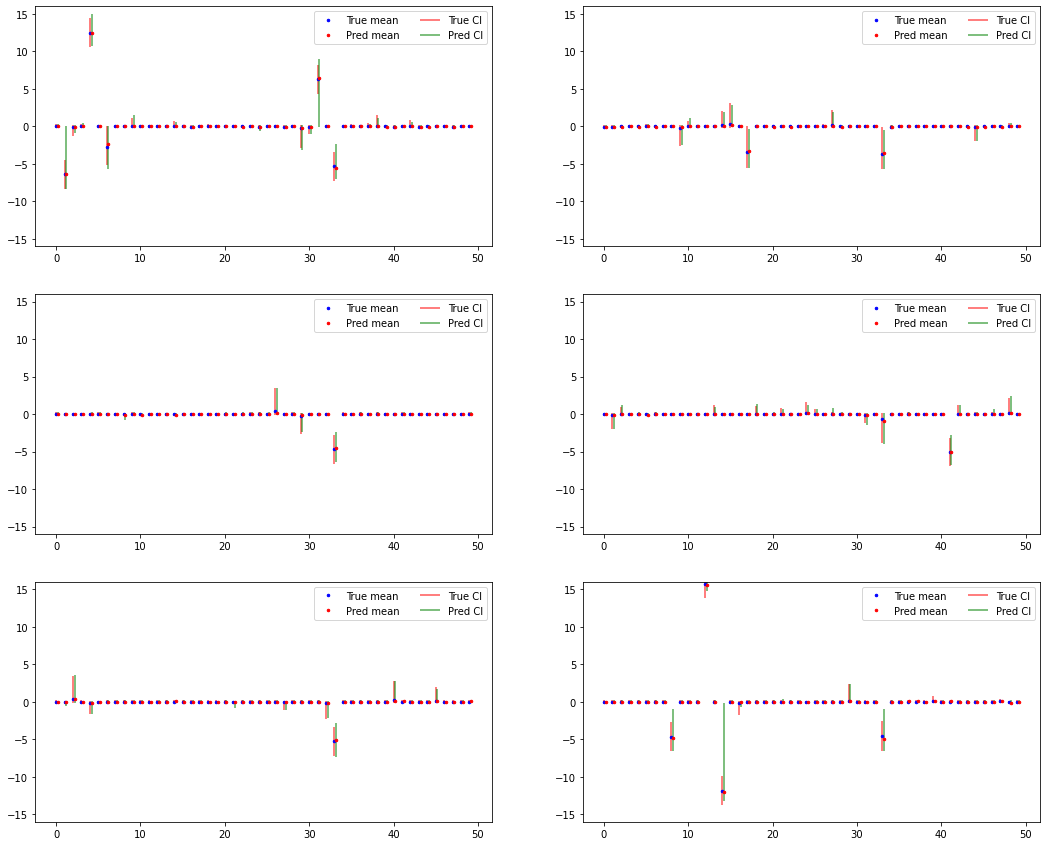

In [28]:
subset = np.where(beta_test[:,33]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

In [29]:
subset

array([2025, 7572, 5190, 9457, 9337,  440], dtype=int64)

In [30]:
np.where(pred_mean[440]<-10)

(array([14], dtype=int64),)

Coordinate 1, 31, 14 are abnormal.

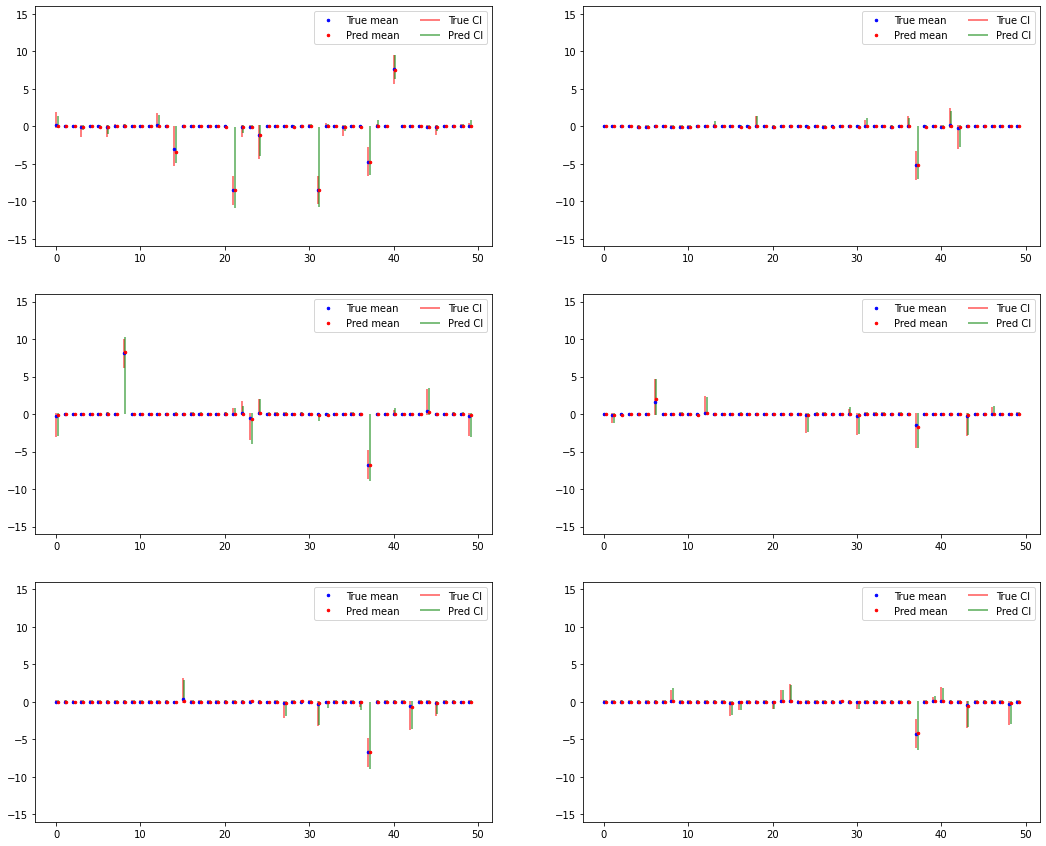

In [34]:
subset = np.where(beta_test[:,37]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

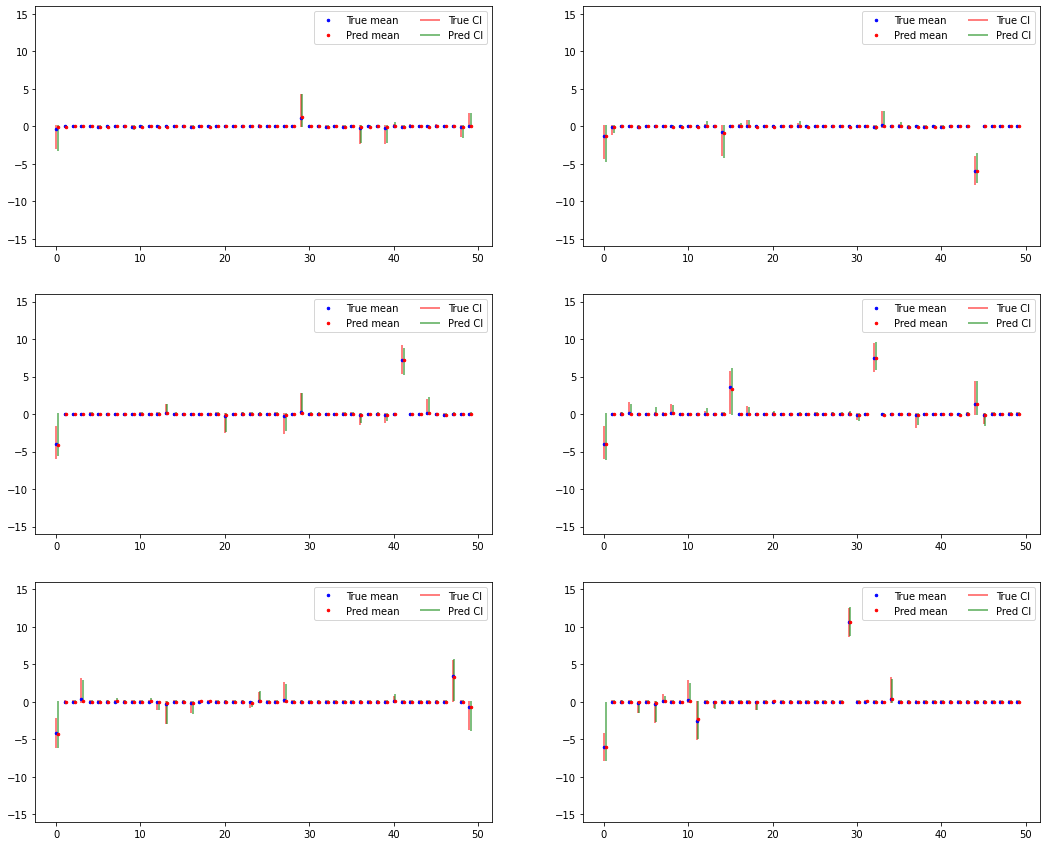

In [36]:
subset = np.where(beta_test[:,0]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

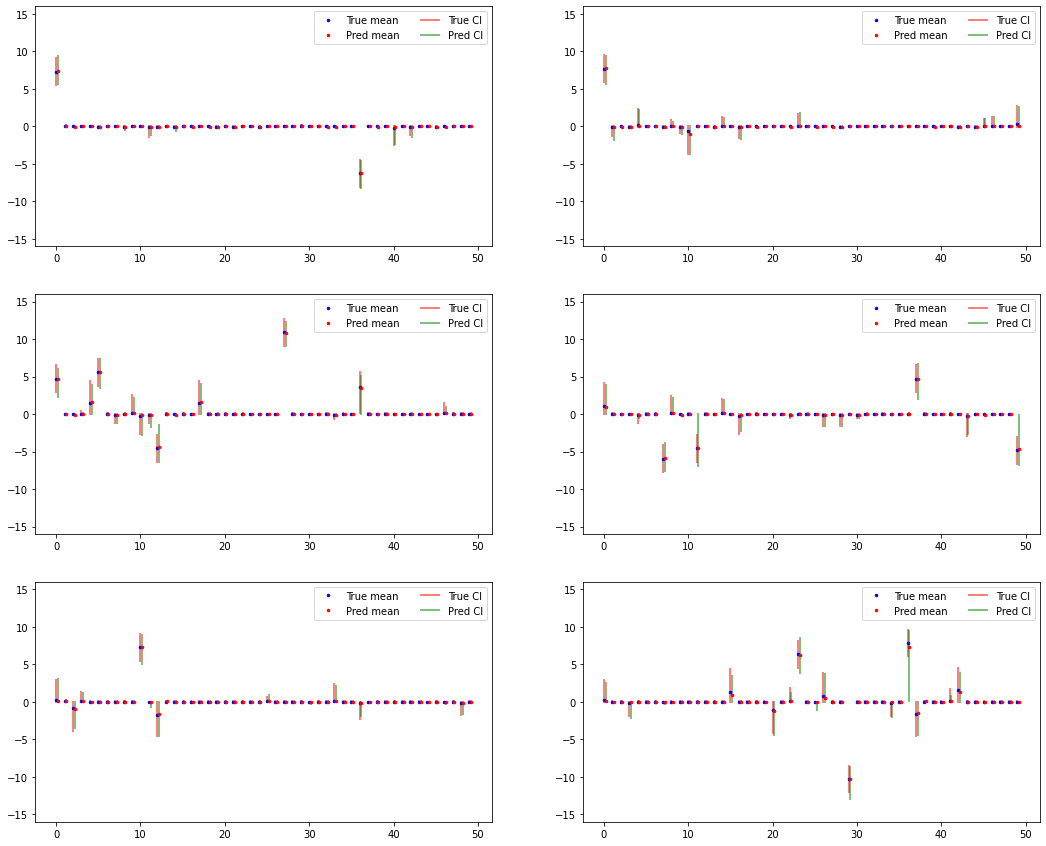

In [43]:
subset = np.where(beta_test[:,0]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

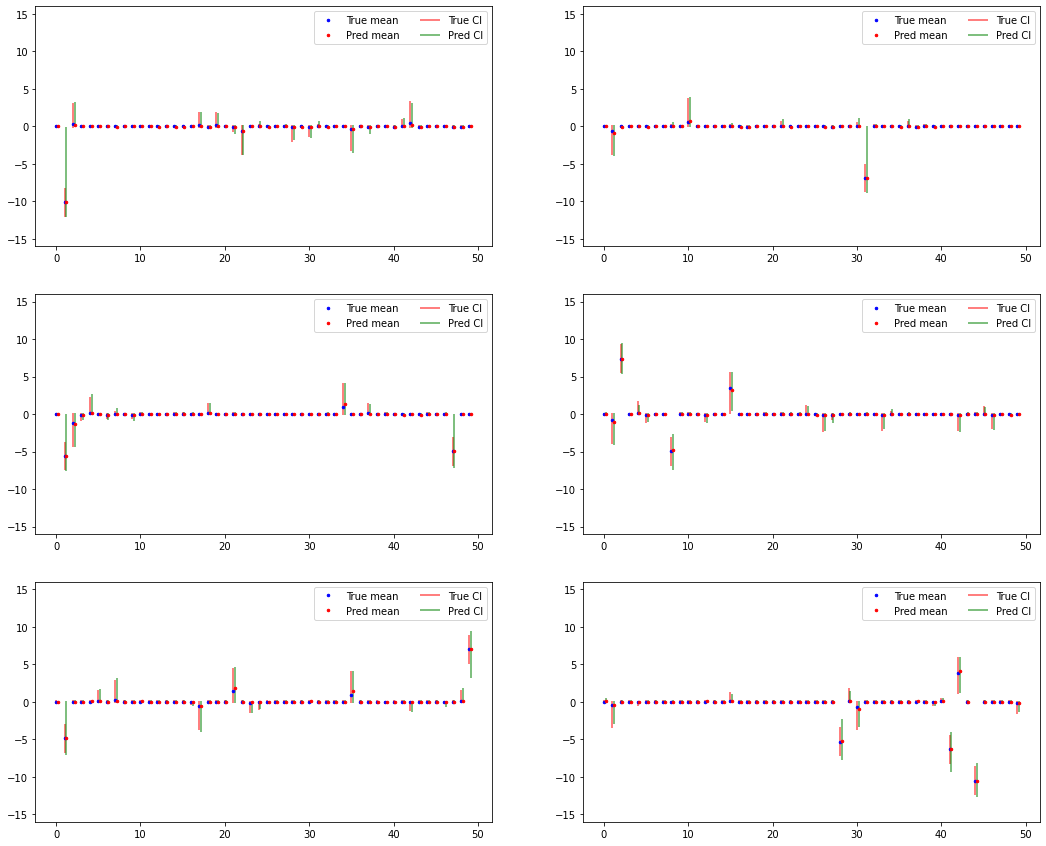

In [38]:
subset = np.where(beta_test[:,1]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

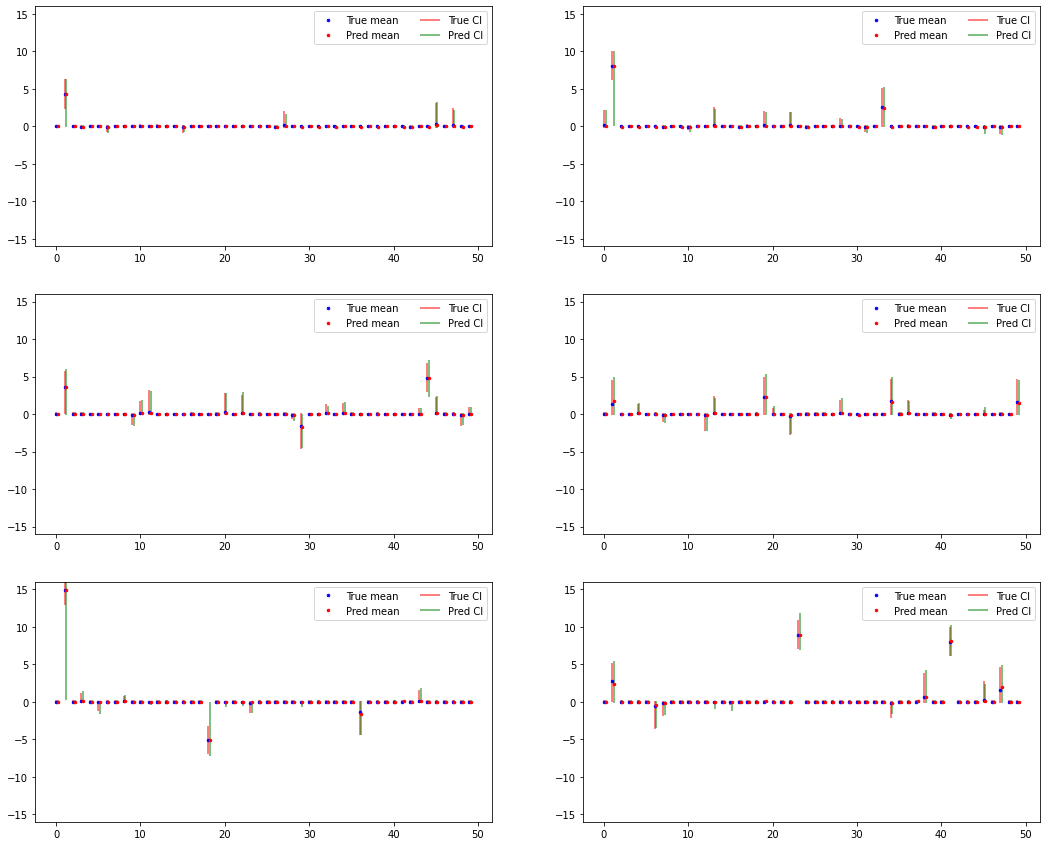

In [41]:
subset = np.where(beta_test[:,1]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

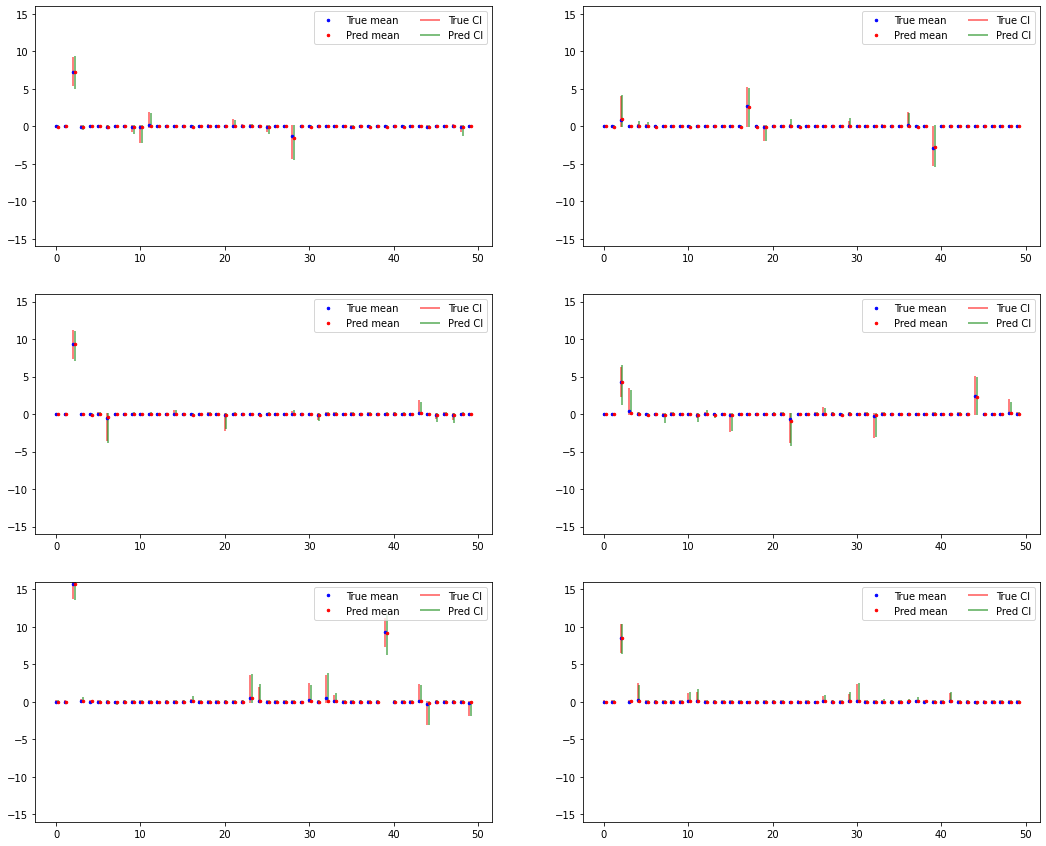

In [44]:
subset = np.where(beta_test[:,2]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

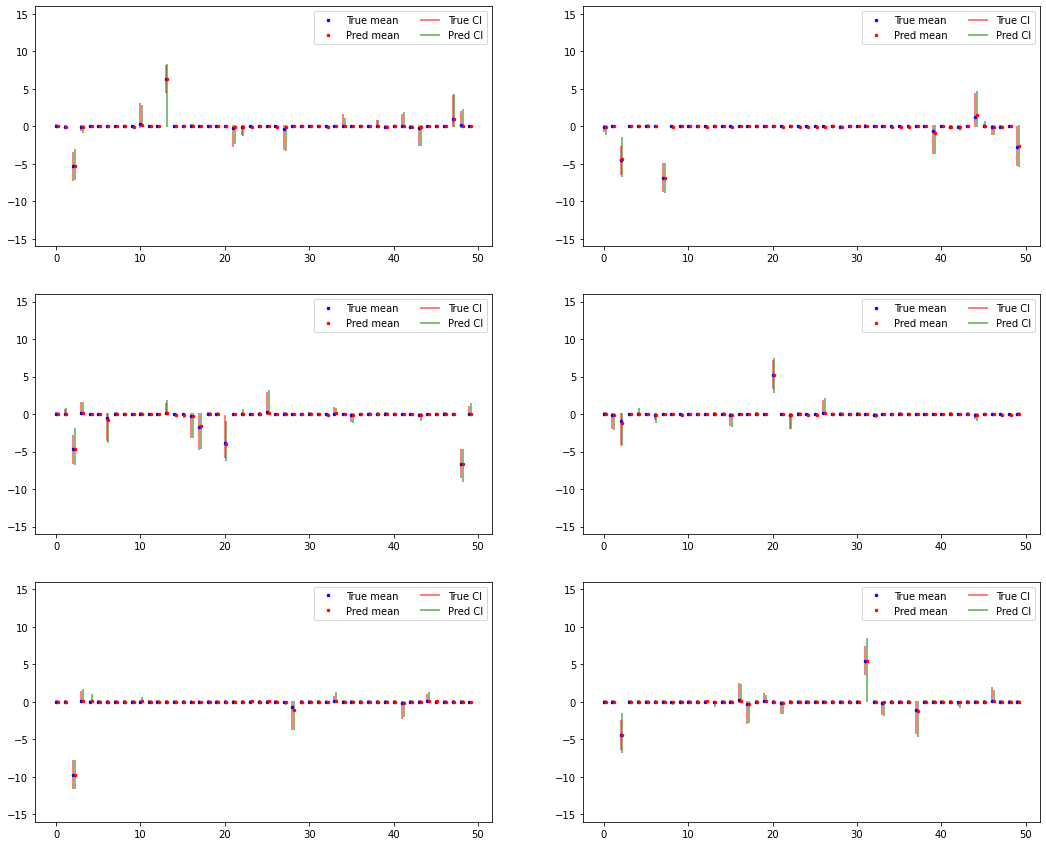

In [46]:
subset = np.where(beta_test[:,2]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

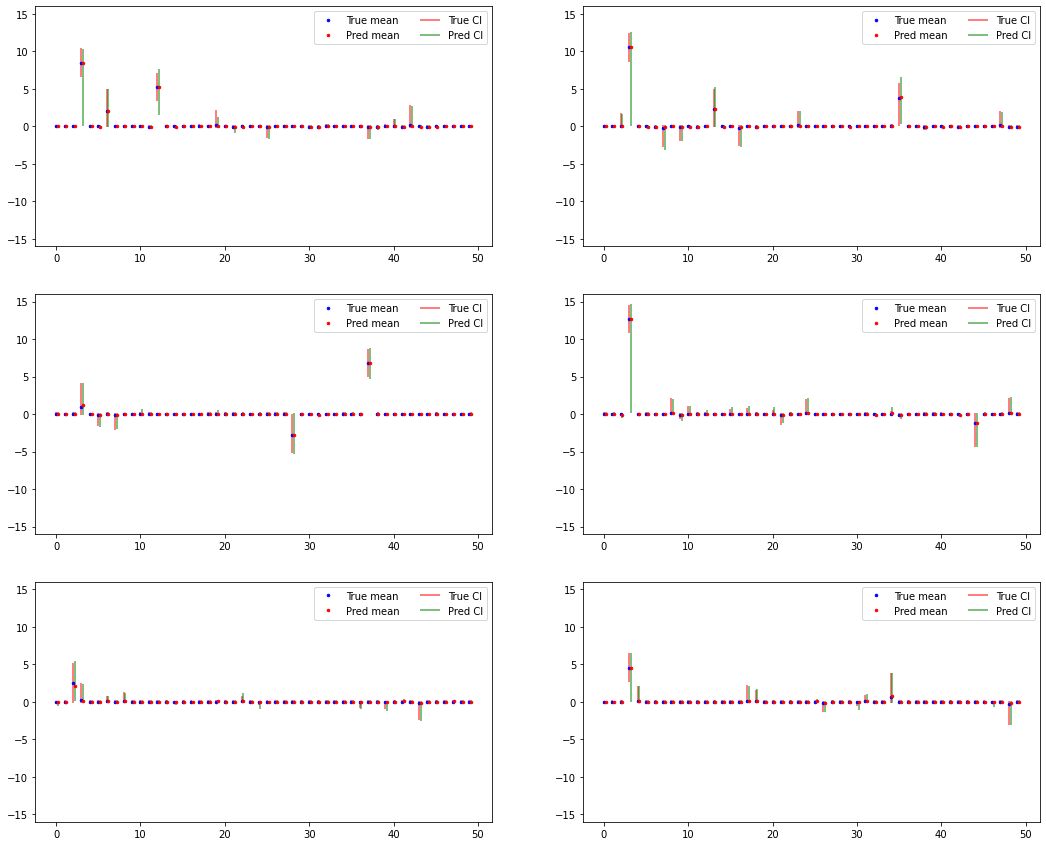

In [48]:
subset = np.where(beta_test[:,3]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

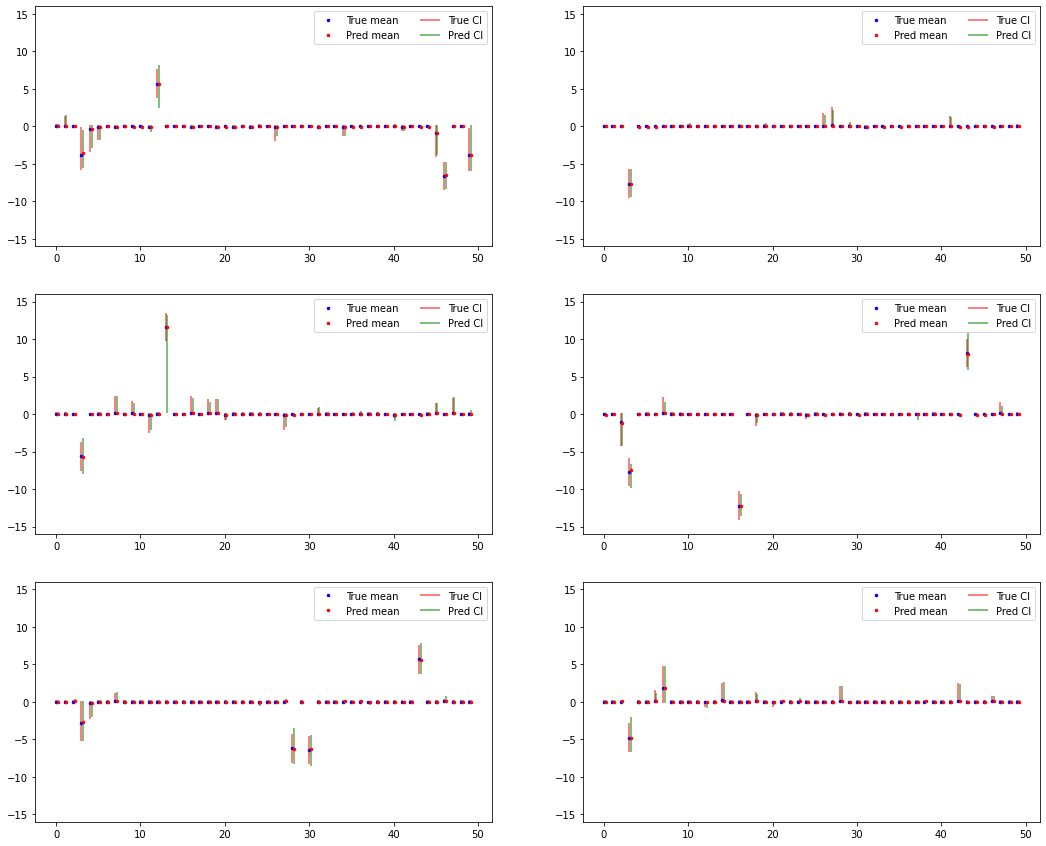

In [49]:
subset = np.where(beta_test[:,3]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

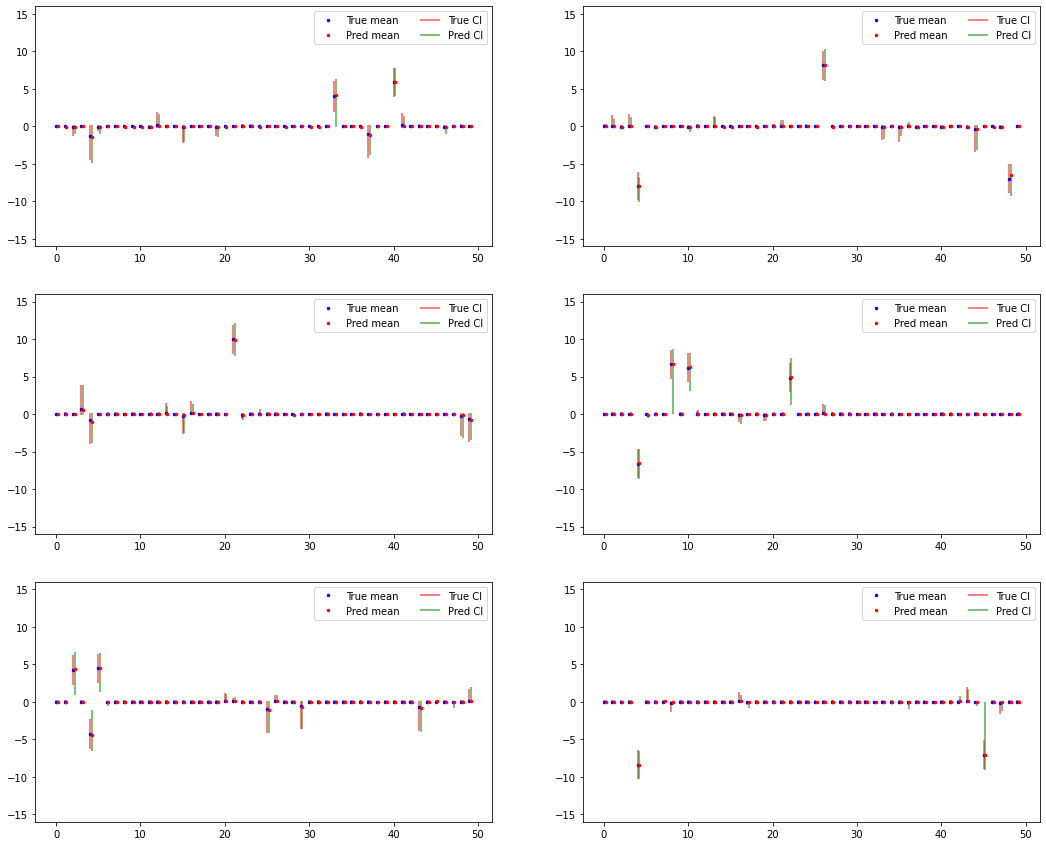

In [52]:
subset = np.where(beta_test[:,4]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

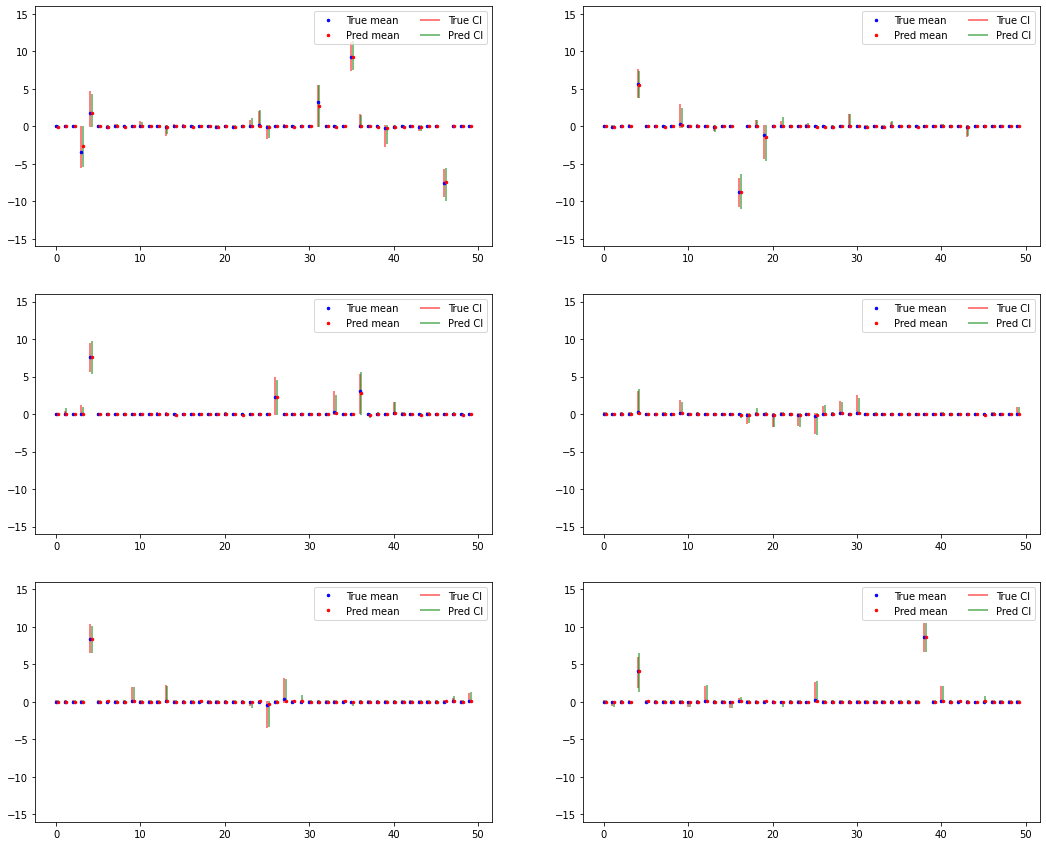

In [54]:
subset = np.where(beta_test[:,4]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

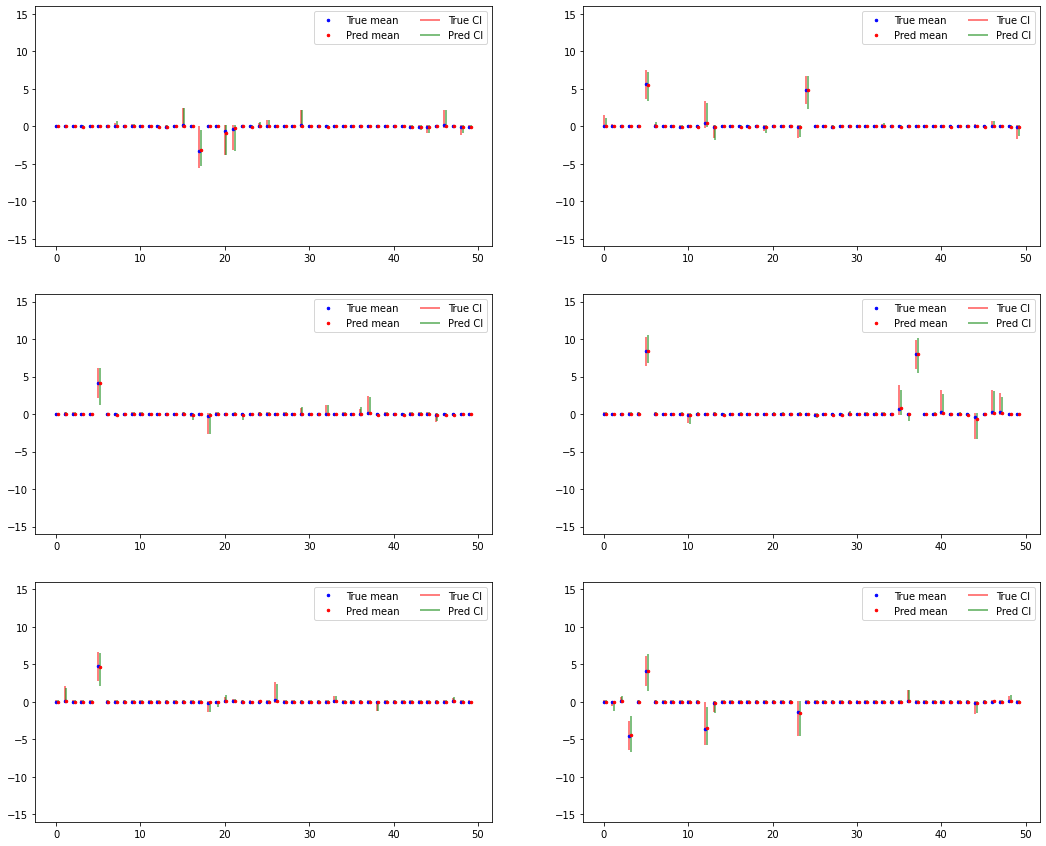

In [57]:
subset = np.where(beta_test[:,5]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

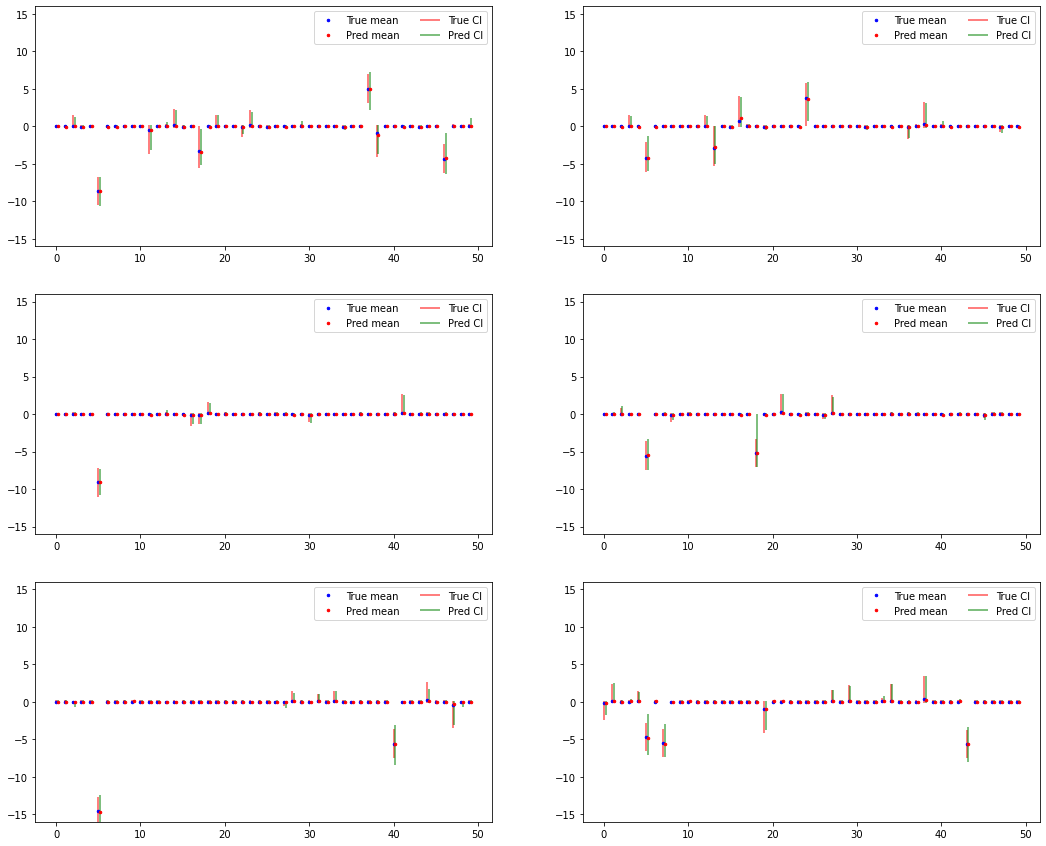

In [58]:
subset = np.where(beta_test[:,5]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

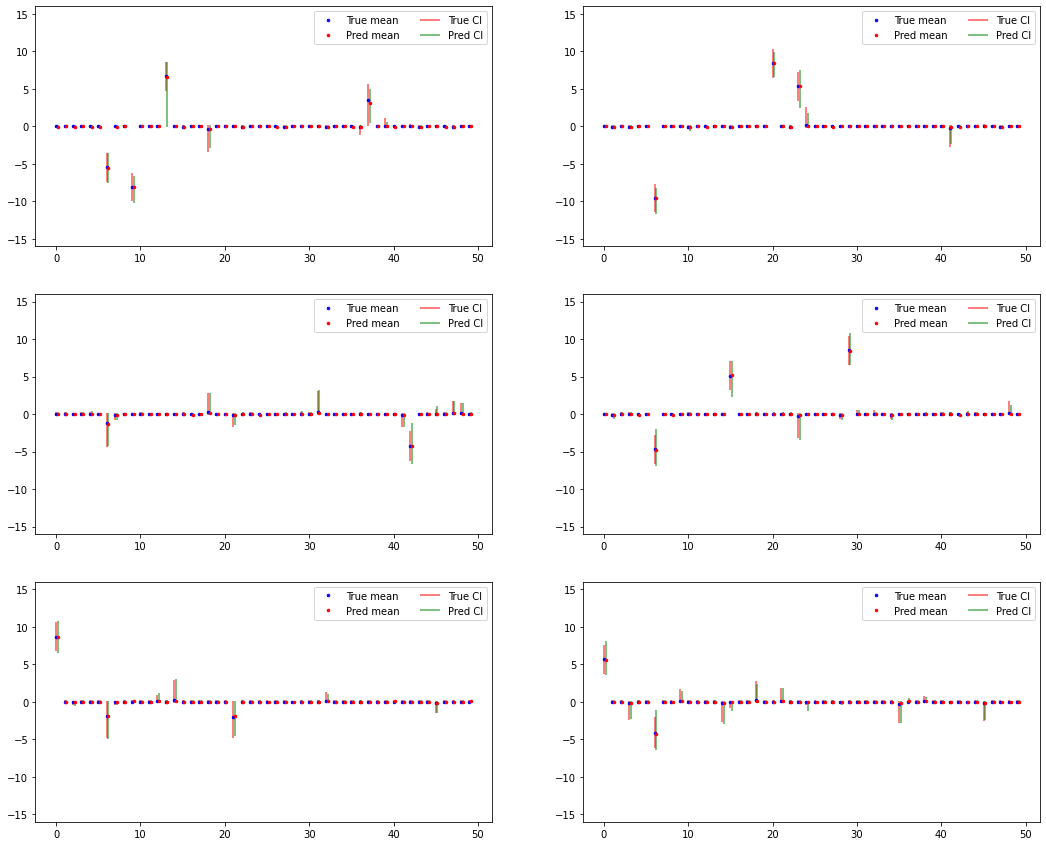

In [59]:
subset = np.where(beta_test[:,6]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

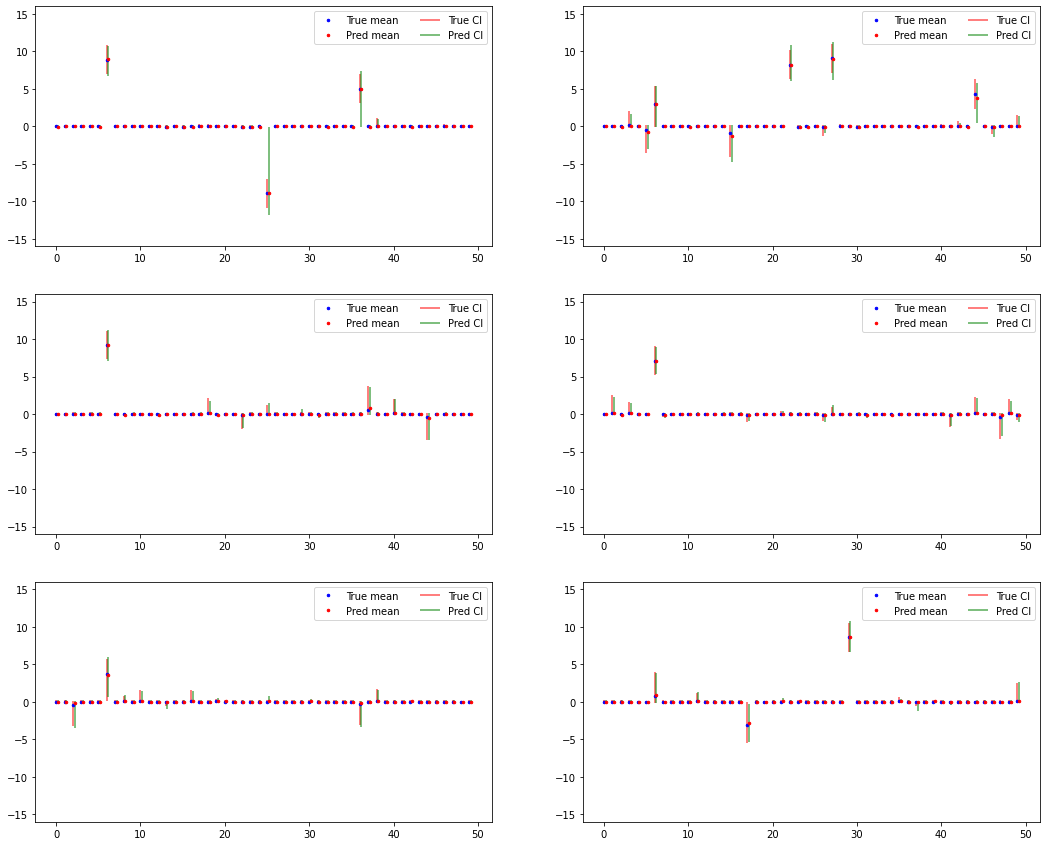

In [60]:
subset = np.where(beta_test[:,6]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

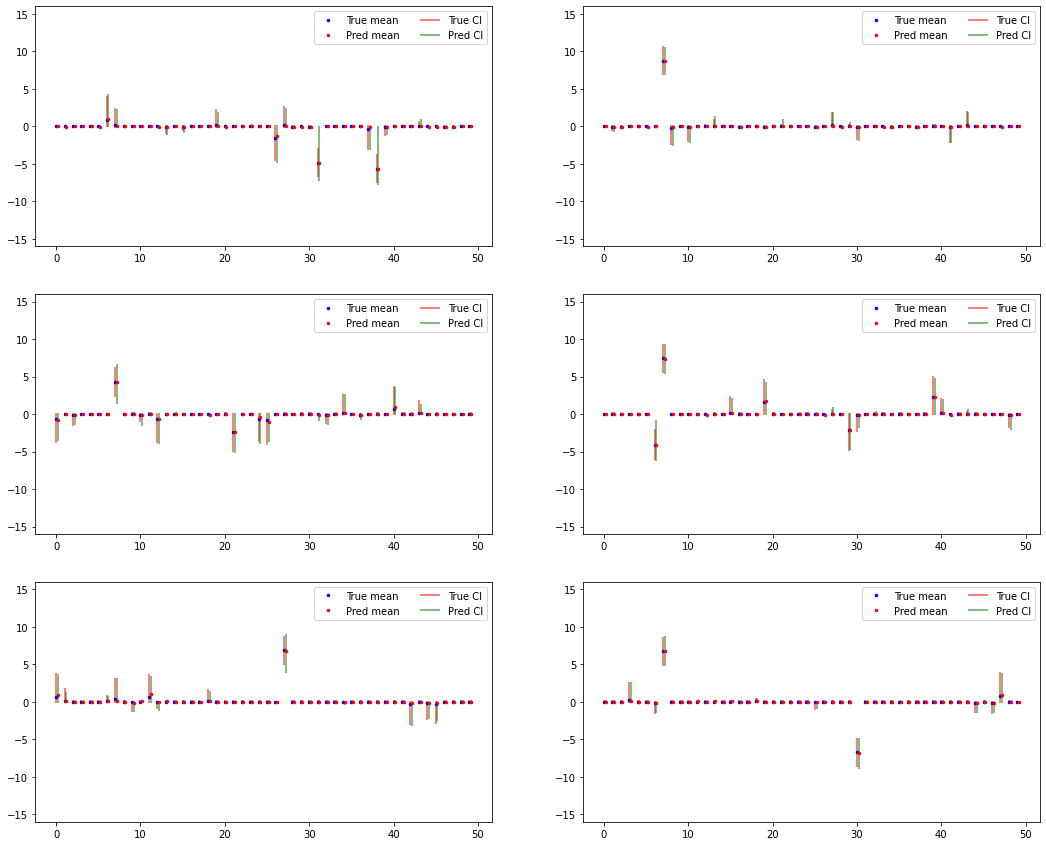

In [64]:
subset = np.where(beta_test[:,7]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

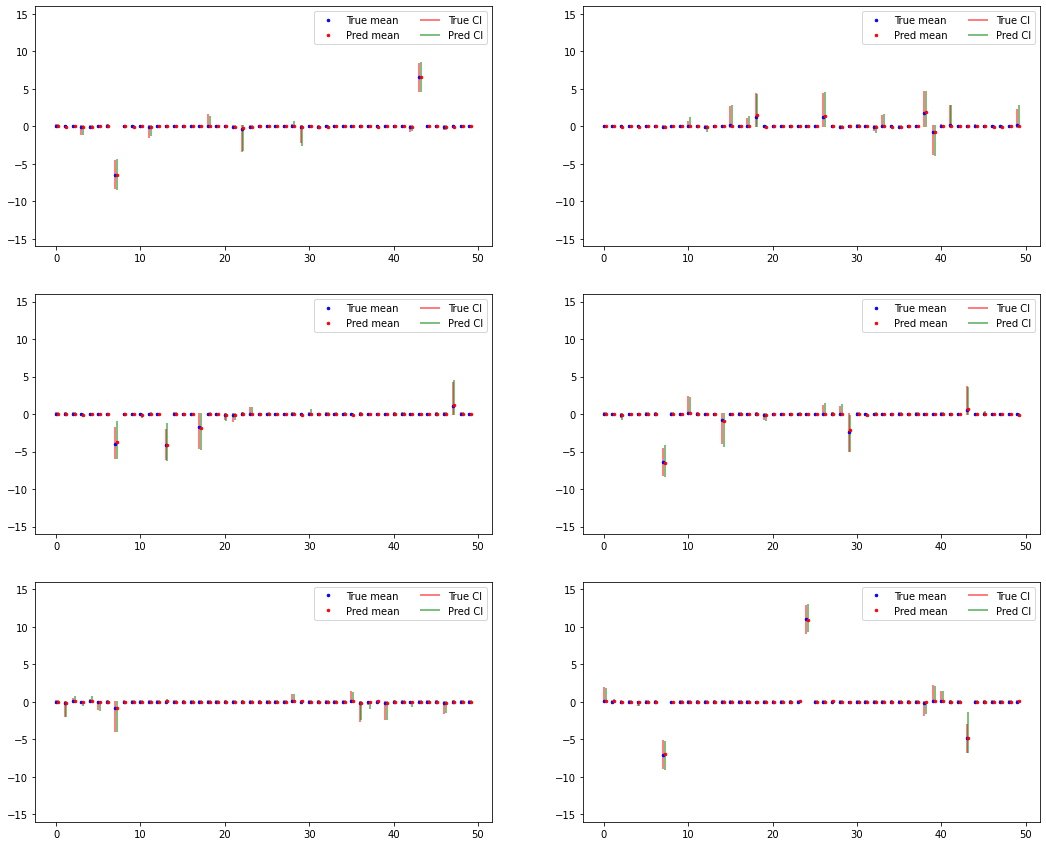

In [66]:
subset = np.where(beta_test[:,7]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

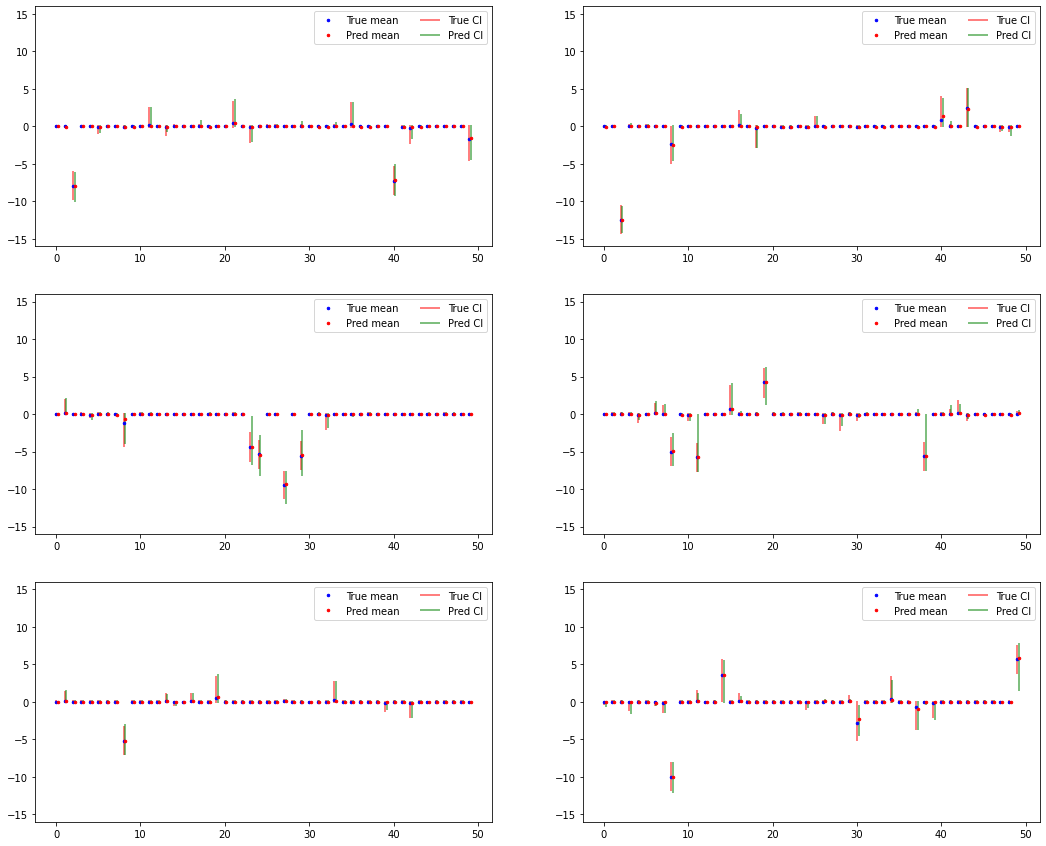

In [69]:
subset = np.where(beta_test[:,8]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

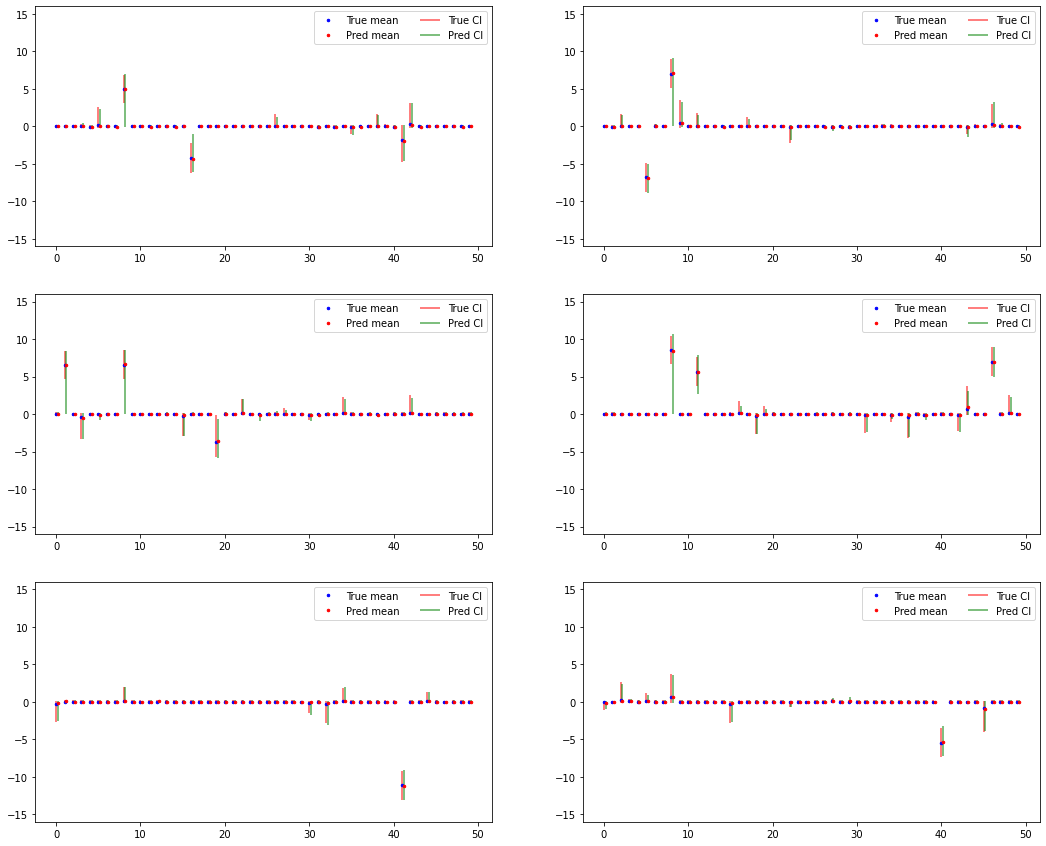

In [72]:
subset = np.where(beta_test[:,8]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

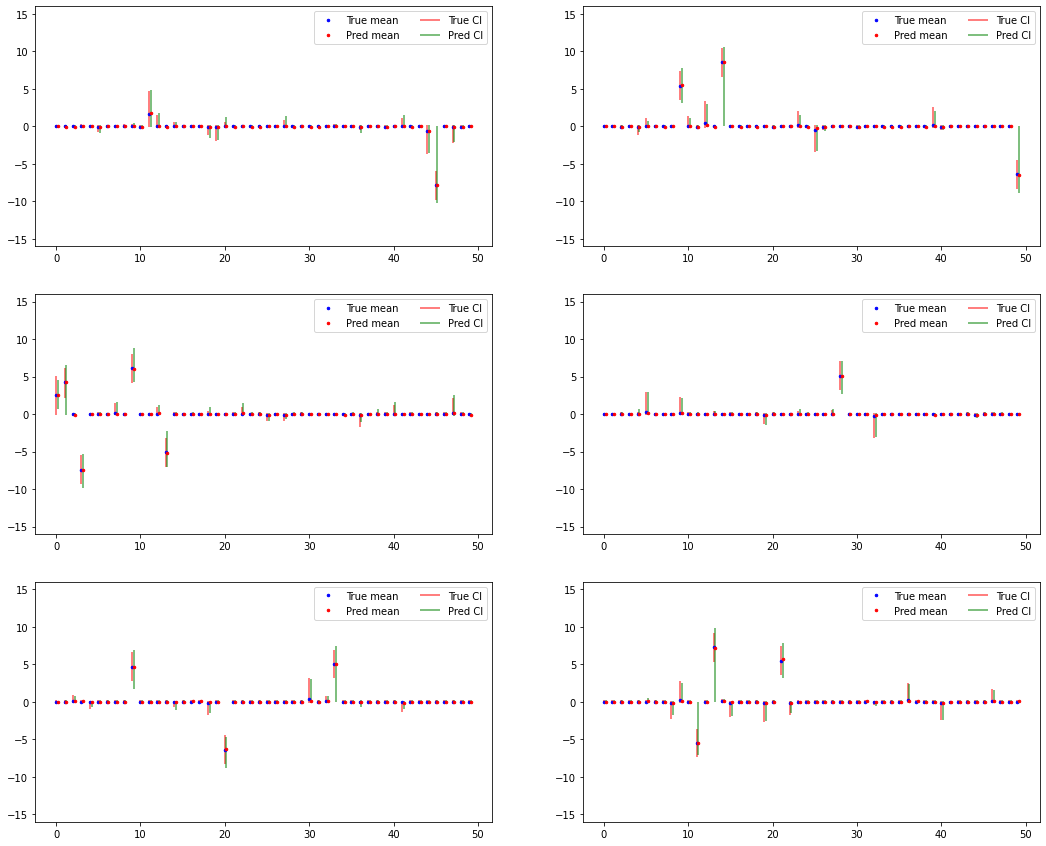

In [74]:
subset = np.where(beta_test[:,9]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

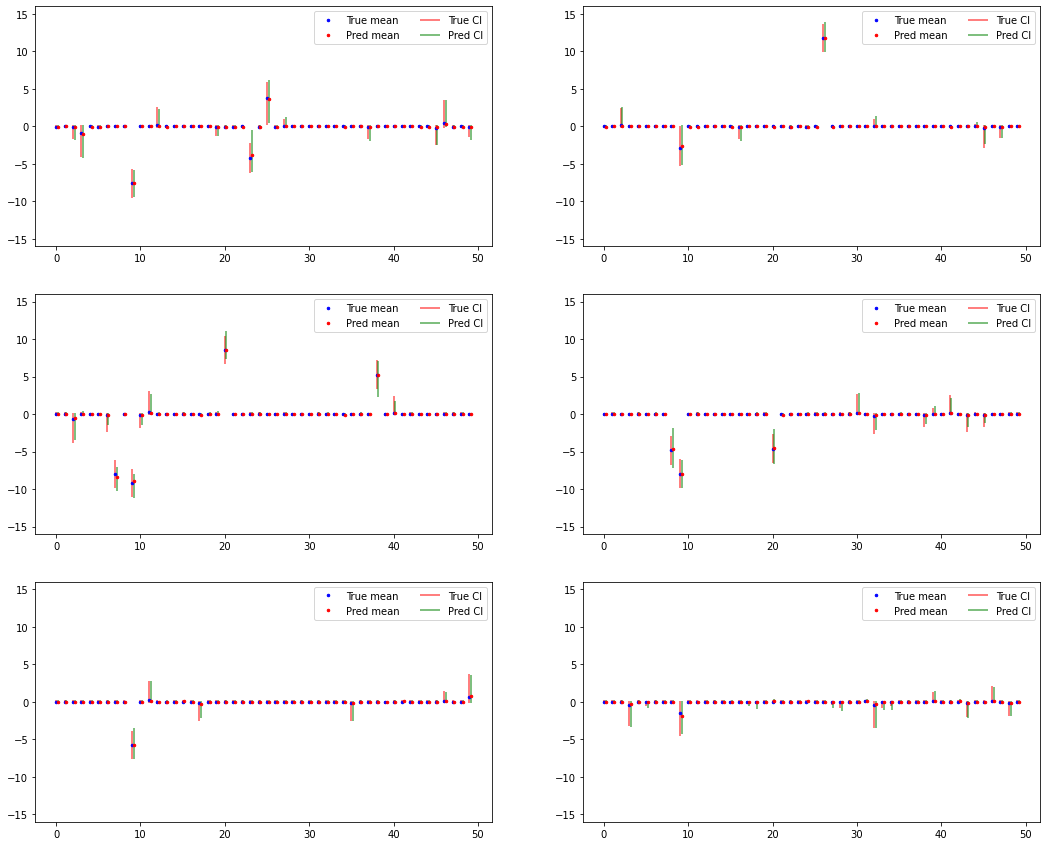

In [76]:
subset = np.where(beta_test[:,9]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

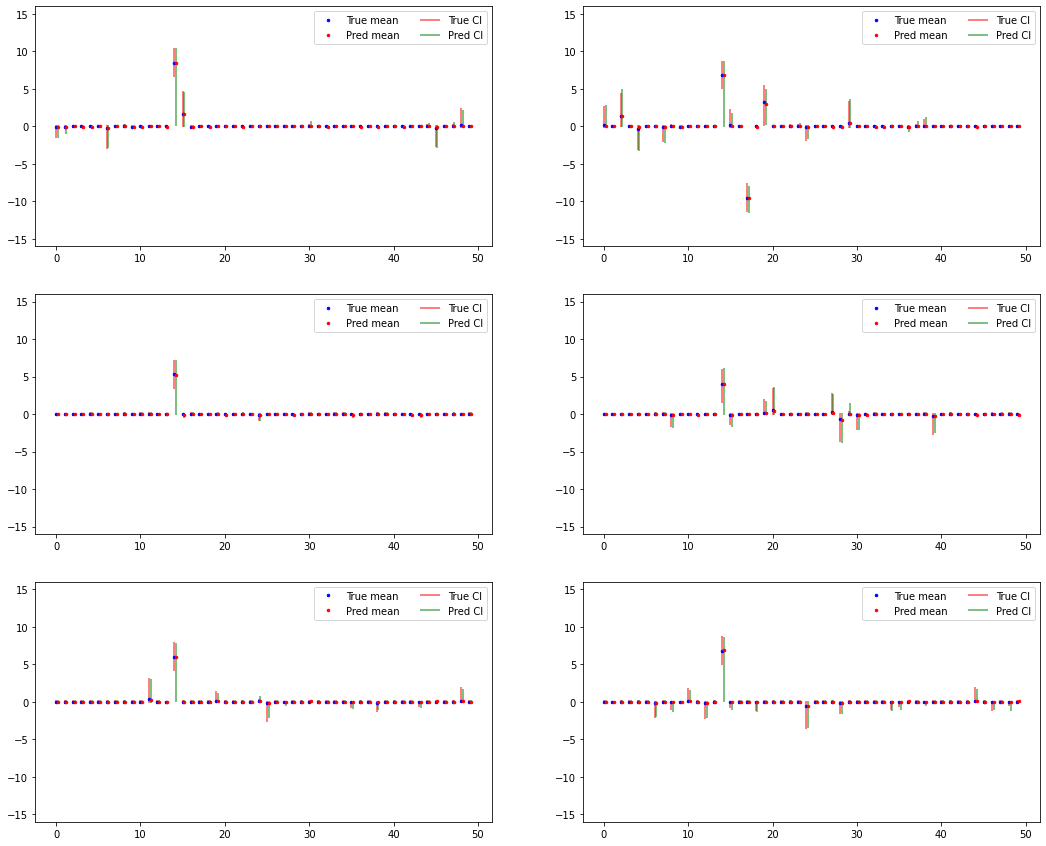

In [61]:
subset = np.where(beta_test[:,14]>2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

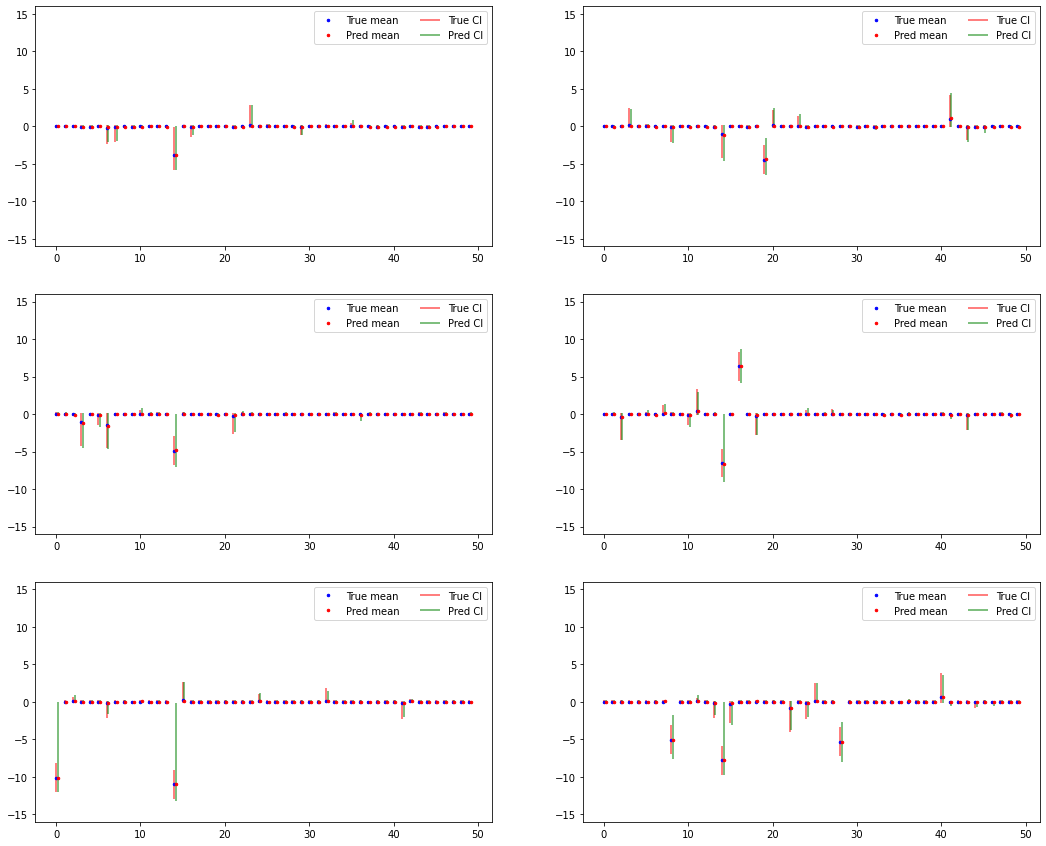

In [63]:
subset = np.where(beta_test[:,14]<-2)[0]
t = 1000 * time.time()
np.random.seed(int(t) % 2**32)
rng.shuffle(subset)
subset = subset[:6]    

for i in subset:
    for j in range(Y_test.shape[1]):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

plt.figure(figsize=(18,15))
for i, idx in enumerate(subset):
    plt.subplot(3,2,i+1)
    plt.plot(range(p), true_mean[idx], '.b', ms=5)
    plt.plot(np.arange(p)+0.2, pred_mean[idx], '.r', ms=5)
    plt.vlines(np.arange(p), true_q025[idx], true_q975[idx], color='red', alpha=0.5, lw=2)
    plt.vlines(np.arange(p)+0.2, pred_q025[idx], pred_q975[idx], color='green', alpha=0.5, lw=2)
    plt.legend(['True mean', 'Pred mean', 'True CI', 'Pred CI'], ncol=2)
    plt.ylim(-16,16)
plt.show()

In [101]:
paras_q025 = []
for name, para in md_q025.named_parameters():
    print(name)
    paras_q025.append(copy.deepcopy(para))

fc_final.weight
fc_final.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


In [102]:
paras_q025[1]

Parameter containing:
tensor([-0.1563, -0.2513, -0.2302, -0.2489, -0.2135, -0.2142, -0.1992, -0.2193,
        -0.2504, -0.2204, -0.2358, -0.2322, -0.2213, -0.2482, -0.2496, -0.2193,
        -0.2120, -0.2493, -0.2424, -0.2215, -0.2046, -0.2065, -0.2178, -0.2051,
        -0.2016, -0.2273, -0.2090, -0.2410, -0.2252, -0.1925, -0.2487, -0.2493,
        -0.2175, -0.2511, -0.2287, -0.2271, -0.2530, -0.2178, -0.2112, -0.2044,
        -0.2220, -0.2184, -0.2056, -0.2100, -0.2154, -0.2268, -0.2155, -0.2166,
        -0.2300, -0.2440], device='cuda:0', requires_grad=True)

In [103]:
paras_q025[0].shape

torch.Size([50, 1024])

In [104]:
torch.sum(paras_q025[0], dim=1)

tensor([-1.1201, -0.9892, -0.9182, -1.0364, -0.6439, -0.6170, -0.7940, -0.7725,
        -0.9795, -0.6344, -0.8943, -0.9003, -0.8848, -0.9763, -1.0441, -0.7087,
        -0.5402, -0.9975, -1.1168, -0.6676, -0.5158, -0.6075, -0.7494, -0.6749,
        -0.6565, -0.7490, -0.3825, -1.2822, -0.7071, -0.7490, -0.8721, -0.8178,
        -0.8635, -0.9034, -0.7123, -0.6270, -1.0083, -0.9661, -0.9333, -0.1823,
        -0.8122, -0.6753, -0.5507, -0.5618, -0.4974, -0.4098, -0.6639, -0.6281,
        -0.7787, -1.1479], device='cuda:0', grad_fn=<SumBackward1>)

In [105]:
paras_q975 = []
for name, para in md_q975.named_parameters():
    print(name)
    paras_q975.append(copy.deepcopy(para))

fc_final.weight
fc_final.bias
fc.0.weight
fc.0.bias
fc.1.weight
fc.1.bias


In [106]:
paras_q975[1]

Parameter containing:
tensor([0.2498, 0.2378, 0.2276, 0.2302, 0.2287, 0.2119, 0.2027, 0.2208, 0.2043,
        0.2203, 0.2332, 0.2508, 0.2147, 0.2094, 0.2483, 0.2202, 0.2321, 0.2305,
        0.2501, 0.2341, 0.2167, 0.2502, 0.2500, 0.2440, 0.1986, 0.2474, 0.1931,
        0.2112, 0.2070, 0.2352, 0.2034, 0.2491, 0.2498, 0.2296, 0.2242, 0.2307,
        0.2245, 0.2516, 0.2519, 0.2009, 0.2086, 0.2179, 0.2214, 0.2280, 0.1818,
        0.2498, 0.2030, 0.2491, 0.2116, 0.2509], device='cuda:0',
       requires_grad=True)

In [107]:
torch.sum(paras_q975[0], dim=1)

tensor([1.0185, 1.0300, 0.8975, 0.9353, 0.8286, 0.5159, 0.7476, 0.8324, 0.4378,
        0.5718, 0.8100, 0.9083, 0.7577, 0.6284, 0.9819, 0.6654, 0.9082, 0.9280,
        0.9631, 0.9114, 0.6267, 1.1047, 0.9916, 1.0730, 0.8931, 0.8481, 0.7062,
        0.6257, 0.5518, 1.1847, 0.4370, 0.8806, 0.9183, 0.9074, 0.5488, 0.6225,
        0.5553, 1.0403, 0.9903, 0.6310, 0.5306, 0.7488, 0.6078, 0.7521, 0.6856,
        0.9512, 0.9239, 0.9805, 0.7280, 0.9822], device='cuda:0',
       grad_fn=<SumBackward1>)

In [112]:
true_mean = np.zeros((2000, p))
true_q025 = np.zeros((2000, p))
true_q975 = np.zeros((2000, p))

for i in tqdm(range(2000)):
    for j in range(p):
        true_mean[i,j], true_q025[i,j], true_q975[i,j] = computeNormalStats(sigma, sigma0, sigma1, Y_test[i,j])

100%|██████████| 2000/2000 [08:50<00:00,  3.77it/s]


In [116]:
q025_loss = np.mean(np.maximum(0.025*(beta_test-pred_q025),0.975*(pred_q025-beta_test)), 0)

In [118]:
q025_loss

array([0.01706063, 0.01938653, 0.01535253, 0.01773532, 0.01538006,
       0.01582795, 0.01673907, 0.016079  , 0.01793372, 0.01556898,
       0.01837853, 0.01694703, 0.0170688 , 0.01796623, 0.01963833,
       0.0164012 , 0.01584523, 0.01842748, 0.01754204, 0.01655128,
       0.01667902, 0.01454373, 0.01597396, 0.01607148, 0.01738645,
       0.01672921, 0.01601778, 0.01813848, 0.01402861, 0.01638289,
       0.01850816, 0.01914368, 0.0157801 , 0.01812363, 0.01718331,
       0.01664773, 0.01769008, 0.01626449, 0.01660128, 0.0172822 ,
       0.01588593, 0.01604687, 0.01661034, 0.01659183, 0.01766705,
       0.01730051, 0.01646583, 0.01806426, 0.01774575, 0.01882685])

In [126]:
q975_loss = np.mean(np.maximum(0.975*(beta_test-pred_q975),0.025*(pred_q975-beta_test)), 0)

In [127]:
q975_loss

array([0.01654935, 0.01792601, 0.01624146, 0.01746714, 0.0173405 ,
       0.01691396, 0.01680193, 0.01627101, 0.01603614, 0.01851529,
       0.01746089, 0.01788625, 0.01705895, 0.01593021, 0.02018532,
       0.01740678, 0.01577221, 0.01785609, 0.01864128, 0.01586554,
       0.01859527, 0.01920893, 0.01935606, 0.01653447, 0.01689832,
       0.018688  , 0.01810338, 0.01821427, 0.0166354 , 0.01632614,
       0.01579137, 0.01671307, 0.01832508, 0.01581979, 0.01682567,
       0.01687291, 0.01603655, 0.01710236, 0.01798051, 0.01747259,
       0.01658298, 0.0176123 , 0.0162842 , 0.01720055, 0.01557557,
       0.01627086, 0.01498947, 0.01893791, 0.01663295, 0.01812416])

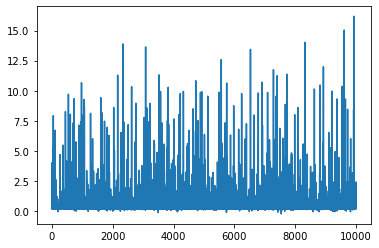

In [134]:
plt.plot(pred_q975[:,0])

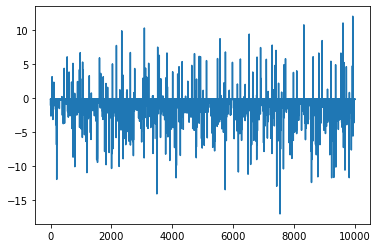

In [135]:
plt.plot(pred_q025[:,0])

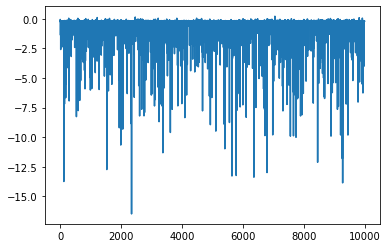

In [136]:
plt.plot(pred_q025[:,1])

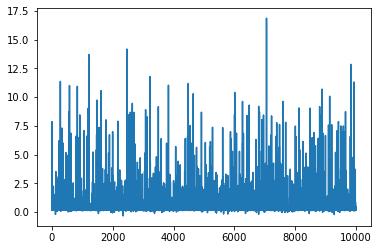

In [137]:
plt.plot(pred_q975[:,1])

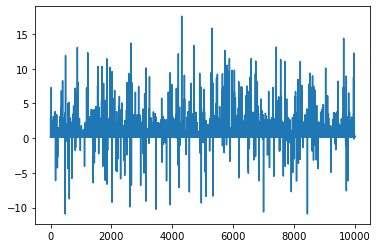

In [138]:
plt.plot(pred_q975[:,2])

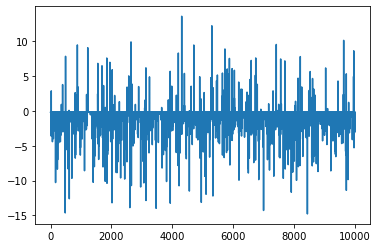

In [139]:
plt.plot(pred_q025[:,2])

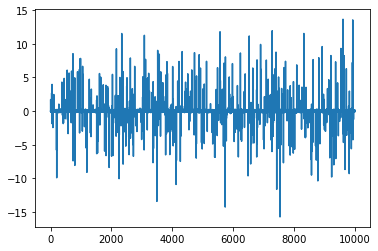

In [140]:
plt.plot(beta_test[:,0])

In [141]:
pred_q025 = predict(md_q025, Y_test_normalized)
pred_q975 = predict(md_q975, Y_test_normalized)
pred_mean = predict(md_mean, Y_test_normalized)

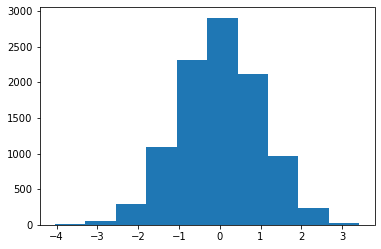

In [162]:
plt.hist(Y_test[:,0]-beta_test[:,0])
plt.show()

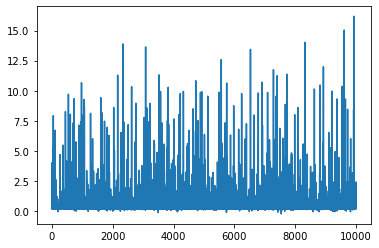

In [142]:
plt.plot(pred_q975[:,0])

In [163]:
np.mean(np.maximum(0.975*(beta_test[:,0]-pred_q975[:,0]), 0.025*(pred_q975[:,0]-beta_test[:,0])))

0.016549351048695437

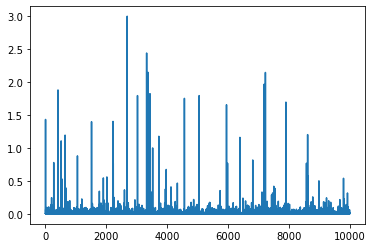

In [164]:
plt.plot(np.maximum(0.975*(beta_test[:,0]-pred_q975[:,0]), 0.025*(pred_q975[:,0]-beta_test[:,0])))

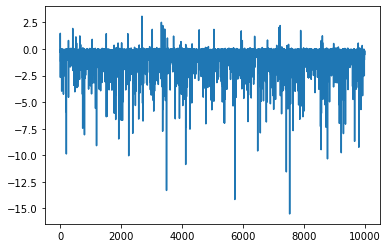

In [167]:
plt.plot(beta_test[:,0]-pred_q975[:,0])

In [152]:
np.sum(beta_test, 0)

array([ -17.95921341,   -7.00620164,   46.67854106,   71.25195162,
        212.98268113,   10.29177461,  140.88875561,  -70.80271251,
        -25.53395015,   31.45788284,  -21.86572089,  -42.81222286,
        -72.55642621, -133.12251115, -133.24376131,   22.25194015,
         19.74164911,   71.97752281, -243.05722494,   -8.94933864,
       -113.23263467,  -83.92846308, -120.67679882,  103.45374533,
         65.19673023,   18.22410379,  -81.30812064,  -53.67548713,
         56.94805262,   16.83296157,  -31.44935001,   29.26632626,
        -73.85355758, -192.50504036, -104.09094132, -146.67629936,
        144.95641033,  202.57533138,   53.59919988, -146.63910185,
        196.31731193,   55.04778147,  -60.91445371, -247.01896442,
       -151.28967011, -223.28654844, -172.02859653,  -84.32334736,
         50.71897602,  209.27955831])

In [169]:
mse_q025 = np.mean((true_q025 - pred_q025[:2000,:])**2, 0)

In [174]:
mse_q025

array([0.00896455, 0.2854383 , 0.00811647, 0.34596124, 0.01100439,
       0.01091902, 0.01235164, 0.01360715, 0.16463319, 0.01325304,
       0.01672316, 0.01237079, 0.01511066, 0.41142364, 0.3546518 ,
       0.01143718, 0.00784429, 0.32985967, 0.01941902, 0.00669578,
       0.00989406, 0.01104058, 0.01186058, 0.01000463, 0.01100962,
       0.01195375, 0.01040015, 0.01977512, 0.00916749, 0.01215493,
       0.28132911, 0.32337297, 0.01013498, 0.16925932, 0.01087114,
       0.00789118, 0.3432308 , 0.01389603, 0.00908089, 0.01219713,
       0.01327286, 0.01343318, 0.01112133, 0.00911196, 0.0119357 ,
       0.01668583, 0.01051638, 0.0088061 , 0.01269626, 0.04620234])

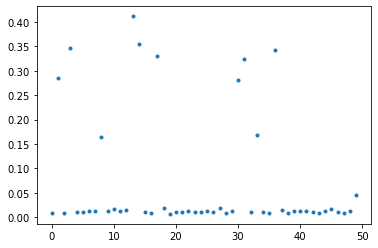

In [172]:
plt.plot(mse_q025,'.')
plt.show()

In [175]:
mse_q975 = np.mean((true_q975 - pred_q975[:2000,:])**2, 0)

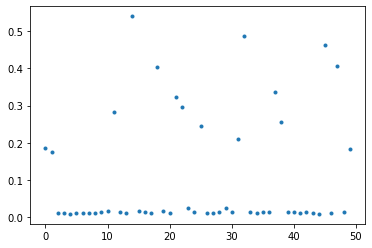

In [176]:
plt.plot(mse_q975,'.')
plt.show()

In [177]:
torch.save(md_q025.state_dict(), './model/p50_q025_week10.pt')
torch.save(md_q975.state_dict(), './model/p50_q975_week10.pt')
torch.save(md_mean.state_dict(), './model/p50_mean_week10.pt')

In [190]:
md_q025_1 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
model_list_q025 = []
save_point = [10, 15, 35, 40, 50, 55, 60, 90, 91, 92, 93, 94, 95]
optimizer = torch.optim.Adam(md_q025_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q025_1, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.025, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std,
                                      model_list=model_list_q025, save_point=save_point)

Epoch: 1
Train loss: 0.02317
Val loss: 0.02024
Epoch: 2
Train loss: 0.01988
Val loss: 0.01977
Epoch: 3
Train loss: 0.01946
Val loss: 0.01954
Epoch: 4
Train loss: 0.01929
Val loss: 0.01936
Epoch: 5
Train loss: 0.01915
Val loss: 0.01927
Epoch: 6
Train loss: 0.01909
Val loss: 0.01926
Epoch: 7
Train loss: 0.01898
Val loss: 0.01908
Epoch: 8
Train loss: 0.01894
Val loss: 0.01916
Epoch: 9
Train loss: 0.01891
Val loss: 0.01894
Epoch: 10
Train loss: 0.01884
Val loss: 0.01900
Epoch: 11
Train loss: 0.01883
Val loss: 0.01896
Epoch: 12
Train loss: 0.01878
Val loss: 0.01900
Epoch: 13
Train loss: 0.01876
Val loss: 0.01890
Epoch: 14
Train loss: 0.01876
Val loss: 0.01896
Epoch: 15
Train loss: 0.01876
Val loss: 0.01884
Epoch: 16
Train loss: 0.01871
Val loss: 0.01887
Epoch: 17
Train loss: 0.01869
Val loss: 0.01881
Epoch: 18
Train loss: 0.01870
Val loss: 0.01882
Epoch: 19
Train loss: 0.01867
Val loss: 0.01893
Epoch: 20
Train loss: 0.01867
Val loss: 0.01881
Epoch: 21
Train loss: 0.01827
Val loss: 0.01834
E

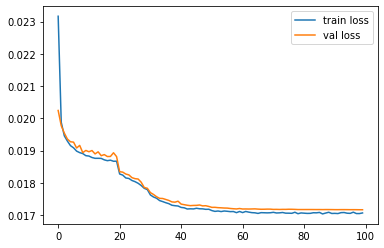

In [191]:
show_loss(train_losses, val_losses)

In [192]:
md_q975_1 = MLP_variant(p, p, [1024, 1024], 'leakyrelu').to(device)
model_list_q975 = []
save_point = [10, 15, 35, 40, 50, 55, 60, 90, 91, 92, 93, 94, 95]
optimizer = torch.optim.Adam(md_q975_1.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 30, 40, 50, 60, 70, 80], gamma=0.4)
train_losses, val_losses = train_model_with_generator(md_q975_1, generator, optimizer, epochs=100, 
                                      batch_size=256, iteration_per_epoch=4000, loss_type='quantile',
                                      q=0.975, val_data=valid_dataloader, scheduler=scheduler, mean=mean, std=std,
                                      model_list=model_list_q975, save_point=save_point)

Epoch: 1
Train loss: 0.02297
Val loss: 0.01972
Epoch: 2
Train loss: 0.01977
Val loss: 0.01928
Epoch: 3
Train loss: 0.01943
Val loss: 0.01896
Epoch: 4
Train loss: 0.01924
Val loss: 0.01897
Epoch: 5
Train loss: 0.01913
Val loss: 0.01871
Epoch: 6
Train loss: 0.01906
Val loss: 0.01876
Epoch: 7
Train loss: 0.01897
Val loss: 0.01869
Epoch: 8
Train loss: 0.01895
Val loss: 0.01865
Epoch: 9
Train loss: 0.01890
Val loss: 0.01855
Epoch: 10
Train loss: 0.01885
Val loss: 0.01852
Epoch: 11
Train loss: 0.01884
Val loss: 0.01851
Epoch: 12
Train loss: 0.01883
Val loss: 0.01855
Epoch: 13
Train loss: 0.01880
Val loss: 0.01845
Epoch: 14
Train loss: 0.01881
Val loss: 0.01847
Epoch: 15
Train loss: 0.01876
Val loss: 0.01839
Epoch: 16
Train loss: 0.01875
Val loss: 0.01837
Epoch: 17
Train loss: 0.01872
Val loss: 0.01844
Epoch: 18
Train loss: 0.01872
Val loss: 0.01836
Epoch: 19
Train loss: 0.01870
Val loss: 0.01837
Epoch: 20
Train loss: 0.01868
Val loss: 0.01833
Epoch: 21
Train loss: 0.01832
Val loss: 0.01787
E

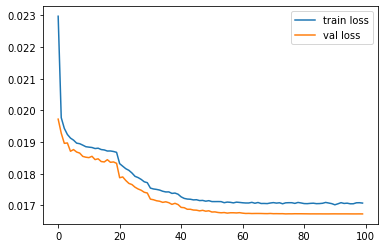

In [193]:
show_loss(train_losses, val_losses)

In [194]:
len(model_list_q975)

13

In [195]:
model_list_q975[-1]

OrderedDict([('fc_final.weight',
              tensor([[-0.0214,  0.0248,  0.0095,  ...,  0.0285, -0.0062, -0.0056],
                      [ 0.0280,  0.0031,  0.0003,  ...,  0.0601,  0.0012, -0.0126],
                      [-0.0221,  0.0024,  0.0269,  ...,  0.0078, -0.0039, -0.0061],
                      ...,
                      [-0.0121, -0.0026,  0.0045,  ..., -0.0049, -0.0120, -0.0065],
                      [ 0.0188,  0.0176, -0.0018,  ..., -0.0055, -0.0106, -0.0025],
                      [-0.0202,  0.0028, -0.0147,  ...,  0.0217, -0.0044,  0.0196]],
                     device='cuda:0')),
             ('fc_final.bias',
              tensor([0.2377, 0.2061, 0.2099, 0.2532, 0.2491, 0.2233, 0.1993, 0.2338, 0.2377,
                      0.2075, 0.2513, 0.2159, 0.2516, 0.1862, 0.2292, 0.2411, 0.2166, 0.2509,
                      0.2072, 0.2523, 0.2025, 0.2271, 0.2264, 0.2363, 0.2501, 0.2503, 0.2152,
                      0.2062, 0.1950, 0.2084, 0.2368, 0.2193, 0.2110, 0.2165, 0.25

In [196]:
model_list_q975[-5]

OrderedDict([('fc_final.weight',
              tensor([[-0.0213,  0.0248,  0.0094,  ...,  0.0285, -0.0063, -0.0055],
                      [ 0.0280,  0.0031,  0.0003,  ...,  0.0600,  0.0014, -0.0126],
                      [-0.0221,  0.0024,  0.0267,  ...,  0.0078, -0.0040, -0.0061],
                      ...,
                      [-0.0120, -0.0025,  0.0046,  ..., -0.0048, -0.0120, -0.0064],
                      [ 0.0188,  0.0175, -0.0018,  ..., -0.0055, -0.0108, -0.0025],
                      [-0.0201,  0.0028, -0.0146,  ...,  0.0217, -0.0044,  0.0197]],
                     device='cuda:0')),
             ('fc_final.bias',
              tensor([0.2376, 0.2062, 0.2099, 0.2533, 0.2491, 0.2233, 0.1993, 0.2338, 0.2377,
                      0.2076, 0.2513, 0.2160, 0.2515, 0.1861, 0.2292, 0.2412, 0.2166, 0.2510,
                      0.2071, 0.2523, 0.2025, 0.2272, 0.2265, 0.2364, 0.2501, 0.2504, 0.2152,
                      0.2062, 0.1950, 0.2083, 0.2368, 0.2191, 0.2109, 0.2165, 0.25

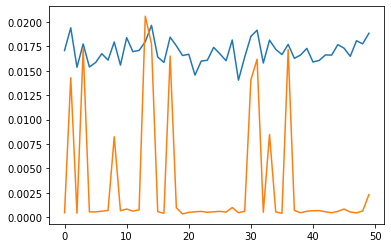

In [199]:
plt.plot(q025_loss)
plt.plot(mse_q025/20)
plt.show()

In [200]:
np.corrcoef(q025_loss, mse_q025)

array([[1.        , 0.63007546],
       [0.63007546, 1.        ]])

In [201]:
np.corrcoef(q975_loss, mse_q975)

array([[1.        , 0.57829441],
       [0.57829441, 1.        ]])